# Dataset preparation

In [ ]:
#import airbus and cgi datasets from kaggle

from google.colab import files

#upload kaggle key
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
import os 
os.environ['KAGGLE_CONFIG_DIR'] = '/content'
!chmod 600 /content/kaggle.json

To save space test images are not saved on test folder but are directly taken from original datasets folders so it is necessary to download them

In [ ]:
#downloading cgi planes dataset and extract
!kaggle datasets download -d aceofspades914/cgi-planes-in-satellite-imagery-w-bboxes

#downloading airbus aircrafts dataset and extract
!kaggle datasets download -d airbusgeo/airbus-aircrafts-sample-dataset

 99% 1.29G/1.30G [00:12<00:00, 106MB/s] 
100% 1.30G/1.30G [00:12<00:00, 115MB/s]
 83% 73.0M/87.6M [00:00<00:00, 79.3MB/s]
100% 87.6M/87.6M [00:00<00:00, 106MB/s] 


In [ ]:
#downloading final dataset 
#if it does not work try many times

!gdown --id 1NZ0eAZRP1u90zjg7SW-R4kknsFqtAf1N

Downloading...
From: https://drive.google.com/uc?id=1NZ0eAZRP1u90zjg7SW-R4kknsFqtAf1N
To: /content/final.zip
100% 4.80G/4.80G [00:47<00:00, 102MB/s] 


In [ ]:
!unzip -q final.zip -d .
!mv ./final/* .
!rm -rf final

In [ ]:
#extract datasets
!unzip -q cgi-planes-in-satellite-imagery-w-bboxes.zip -d ./cgi_planes_dataset
!unzip -q airbus-aircrafts-sample-dataset.zip -d ./airbus_dataset

#removing downloaded zips to save space
!rm cgi-planes-in-satellite-imagery-w-bboxes.zip
!rm airbus-aircrafts-sample-dataset.zip

In [ ]:
#only this version of imgaug support labels
!pip install imgaug==0.4.0

In [ ]:
from csv import reader
import imgaug as ia
import imageio
import os
import json
import imgaug.augmenters as augs
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

### Calculating final dataset size

In [ ]:
f = open('train/train.json', "r")
v = open('validation/validation.json', "r")
t = open('test/test.json', "r")

train_dict = json.load(f)
validation_dict = json.load(v)
test_dict = json.load(t)

TRAIN_SIZE = len(train_dict.keys())
VALIDATION_SIZE = len(validation_dict.keys())
TEST_SIZE = len(test_dict.keys())

print("Training images: " +str(TRAIN_SIZE))
print("Validation samples: " + str(VALIDATION_SIZE))
print("Test samples: " + str(TEST_SIZE))

f.close()
v.close()
t.close()

Training images: 1554
Validation samples: 424
Test samples: 81


# Preparation for training

In this section function needed for model building and data reading from datasets are defined

In [ ]:
#data preparation

import numpy as np
import tensorflow as tf
import cv2

#network configuration
config = {
    "model": {
        "name": "ssd_vgg16",
        "input_size": 300,
        "l2_regularization": 0.0005,
        "kernel_initializer": "he_normal",
        "base_network_trainable": False,
        "default_boxes": {
            "extra_box_for_ar_1": True,
            "clip_boxes": True,
            "variances": [
                0.1,
                0.1,
                0.2,
                0.2
            ],
            "min_scale": 0.1,
            "max_scale": 1.05,
            "layers": [
                {
                    "name": "conv4_3",
                    "size": 38,
                    "offset": [
                        0.5,
                        0.5
                    ],
                    "aspect_ratios": [
                        1.0,
                        2.0,
                        0.5
                    ]
                },
                {
                    "name": "fc7",
                    "size": 19,
                    "offset": [
                        0.5,
                        0.5
                    ],
                    "aspect_ratios": [
                        1.0,
                        2.0,
                        0.5,
                        3.0,
                        0.33
                    ]
                },
                {
                    "name": "conv8_2",
                    "size": 10,
                    "offset": [
                        0.5,
                        0.5
                    ],
                    "aspect_ratios": [
                        1.0,
                        2.0,
                        0.5,
                        3.0,
                        0.33
                    ]
                },
                {
                    "name": "conv9_2",
                    "size": 5,
                    "offset": [
                        0.5,
                        0.5
                    ],
                    "aspect_ratios": [
                        1.0,
                        2.0,
                        0.5,
                        3.0,
                        0.33
                    ]
                },
                {
                    "name": "conv10_2",
                    "size": 3,
                    "offset": [
                        0.5,
                        0.5
                    ],
                    "aspect_ratios": [
                        1.0,
                        2.0,
                        0.5
                    ]
                },
                {
                    "name": "conv11_2",
                    "size": 1,
                    "offset": [
                        0.5,
                        0.5
                    ],
                    "aspect_ratios": [
                        1.0,
                        2.0,
                        0.5
                    ]
                }
            ]
        }
    },
    "training": {
        "match_threshold": 0.5,
        "neutral_threshold": 0.3,
        "min_negative_boxes": 0,
        "negative_boxes_ratio": 3,
        "alpha": 1,
        "optimizer": {
            "name": "adam",
            "beta_1": 0.9,
            "beta_2": 0.999,
            "epsilon": 1e-08,
            "decay": 0.0,
            "momentum": 0.9,
            "nesterov": False
        }
    }
}

def one_hot_class_label(classname, label_maps):
    """ Turn classname to one hot encoded label.

    Args:
        - classname: String representing the classname
        - label_maps: A list of strings containing all the classes

    Returns:
        - A numpy array of shape (len(label_maps), )

    Raises:
        - Classname does not includes in label maps
    """
    assert classname in label_maps, "classname must be included in label maps"
    temp = np.zeros((len(label_maps)), dtype=np.int)
    temp[label_maps.index(classname)] = 1
    return temp

def center_to_corner(boxes):
    """ Convert bounding boxes from center format (cx, cy, width, height) to corner format (xmin, ymin, xmax, ymax)

    Args:
        - boxes: numpy array of tensor containing all the boxes to be converted

    Returns:
        - A numpy array or tensor of converted boxes
    """
    temp = boxes.copy()
    temp[..., 0] = boxes[..., 0] - (boxes[..., 2] / 2)  # xmin
    temp[..., 1] = boxes[..., 1] - (boxes[..., 3] / 2)  # ymin
    temp[..., 2] = boxes[..., 0] + (boxes[..., 2] / 2)  # xmax
    temp[..., 3] = boxes[..., 1] + (boxes[..., 3] / 2)  # ymax
    return temp

def iou(box_group1, box_group2):
    """ Calculates the intersection over union (aka. Jaccard Index) between two boxes.
    Boxes are assumed to be in corners format (xmin, ymin, xmax, ymax)

    Args:
    - box_group1: boxes in group 1
    - box_group2: boxes in group 2

    Returns:
    - A numpy array of shape (len(box_group1), len(box_group2)) where each value represents the iou between a box in box_group1 to a box in box_group2

    Raises:
    - The shape of box_group1 and box_group2 are not the same.

    Code References:
    - https://stackoverflow.com/questions/28723670/intersection-over-union-between-two-detections/41660682
    """
    assert box_group1.shape == box_group2.shape, "The two boxes array must be the same shape."
    xmin_intersect = np.maximum(box_group1[..., 0], box_group2[..., 0])
    ymin_intersect = np.maximum(box_group1[..., 1], box_group2[..., 1])
    xmax_intersect = np.minimum(box_group1[..., 2], box_group2[..., 2])
    ymax_intersect = np.minimum(box_group1[..., 3], box_group2[..., 3])

    intersect = (xmax_intersect - xmin_intersect) * (ymax_intersect - ymin_intersect)
    box_group1_area = (box_group1[..., 2] - box_group1[..., 0]) * (box_group1[..., 3] - box_group1[..., 1])
    box_group2_area = (box_group2[..., 2] - box_group2[..., 0]) * (box_group2[..., 3] - box_group2[..., 1])
    union = box_group1_area + box_group2_area - intersect
    res = intersect / union

    # set invalid ious to zeros
    res[xmax_intersect < xmin_intersect] = 0
    res[ymax_intersect < ymin_intersect] = 0
    res[res < 0] = 0
    res[res > 1] = 0
    return res


def encode_bboxes(y, epsilon=10e-5):
    """ Encode the label to a proper format suitable for training SSD network.

    Args:
        - y: A numpy of shape (num_default_boxes, num_classes + 12) representing a label sample.

    Returns:
        - A numpy array with the same shape as y but its gt boxes values has been encoded to the proper SSD format.

    Paper References:
        - Liu, W., Anguelov, D., Erhan, D., Szegedy, C., Reed, S., Fu, C.Y., & Berg, A. C. (2016).
          SSD: Single Shot MultiBox Detector. https://arxiv.org/abs/1512.02325

    Webpage References:
        - https://leimao.github.io/blog/Bounding-Box-Encoding-Decoding/

    Code References:
        - https://github.com/pierluigiferrari/ssd_keras/blob/master/ssd_encoder_decoder/ssd_input_encoder.py
    """
    gt_boxes = y[:, -12:-8]
    df_boxes = y[:, -8:-4]
    variances = y[:, -4:]
    encoded_gt_boxes_cx = ((gt_boxes[:, 0] - df_boxes[:, 0]) / (df_boxes[:, 2])) / np.sqrt(variances[:, 0])
    encoded_gt_boxes_cy = ((gt_boxes[:, 1] - df_boxes[:, 1]) / (df_boxes[:, 3])) / np.sqrt(variances[:, 1])
    encoded_gt_boxes_w = np.log(epsilon + gt_boxes[:, 2] / df_boxes[:, 2]) / np.sqrt(variances[:, 2])
    encoded_gt_boxes_h = np.log(epsilon + gt_boxes[:, 3] / df_boxes[:, 3]) / np.sqrt(variances[:, 3])
    y[:, -12] = encoded_gt_boxes_cx
    y[:, -11] = encoded_gt_boxes_cy
    y[:, -10] = encoded_gt_boxes_w
    y[:, -9] = encoded_gt_boxes_h
    return y

def match_gt_boxes_to_default_boxes(
    gt_boxes,
    default_boxes,
    match_threshold=0.5,
    neutral_threshold=0.3
):
    """ Matches ground truth bounding boxes to default boxes based on the SSD paper.

    'We begin by matching each ground truth box to the default box with the best jaccard overlap (as in MultiBox [7]).
    Unlike MultiBox, we then match default boxes to any ground truth with jaccard overlap higher than a threshold (0.5)'

    Args:
        - gt_boxes: A numpy array or tensor of shape (num_gt_boxes, 4). Structure [cx, cy, w, h]
        - default_boxes: A numpy array of tensor of shape (num_default_boxes, 4). Structure [cx, cy, w, h]
        - threshold: A float representing a target to decide whether the box is matched
        - default_boxes: A numpy array of tensor of shape (num_default_boxes, 4). Structure [cx, cy, w, h]

    Returns:
        - matches: A numpy array of shape (num_matches, 2). The first index in the last dimension is the index
          of the ground truth box and the last index is the default box index.
        - neutral_boxes: A numpy array of shape (num_neutral_boxes, 2). The first index in the last dimension is the index
          of the ground truth box and the last index is the default box index.

    Raises:
        - Either the shape of ground truth's boxes array or the default boxes array is not 2

    Code References:
        - https://github.com/pierluigiferrari/ssd_keras/blob/master/ssd_encoder_decoder/matching_utils.py

    Paper References:
        - Liu, W., Anguelov, D., Erhan, D., Szegedy, C., Reed, S., Fu, C.Y., & Berg, A. C. (2016).
          SSD: Single Shot MultiBox Detector. https://arxiv.org/abs/1512.02325
    """

    assert len(gt_boxes.shape) == 2, "Shape of ground truth boxes array must be 2"
    assert len(default_boxes.shape) == 2, "Shape of default boxes array must be 2"

    # convert gt_boxes and default_boxes to [xmin, ymin, xmax, ymax]
    gt_boxes = center_to_corner(gt_boxes)
    default_boxes = center_to_corner(default_boxes)

    num_gt_boxes = gt_boxes.shape[0]
    num_default_boxes = default_boxes.shape[0]

    matches = np.zeros((num_gt_boxes, 2), dtype=np.int)

    # match ground truth to default box with highest iou
    for i in range(num_gt_boxes):
        gt_box = gt_boxes[i]
        gt_box = np.tile(
            np.expand_dims(gt_box, axis=0),
            (num_default_boxes, 1)
        )
        ious = iou(gt_box, default_boxes)
        matches[i] = [i, np.argmax(ious)]

    # match default boxes to ground truths with overlap higher than threshold
    gt_boxes = np.tile(np.expand_dims(gt_boxes, axis=1), (1, num_default_boxes, 1))
    default_boxes = np.tile(np.expand_dims(default_boxes, axis=0), (num_gt_boxes, 1, 1))
    ious = iou(gt_boxes, default_boxes)
    ious[:, matches[:, 1]] = 0

    matched_gt_boxes_idxs = np.argmax(ious, axis=0)  # for each default boxes, select the ground truth box that has the highest iou
    matched_ious = ious[matched_gt_boxes_idxs, list(range(num_default_boxes))]  # get iou scores between gt and default box that were selected above
    matched_df_boxes_idxs = np.nonzero(matched_ious >= match_threshold)[0]  # select only matched default boxes that has iou larger than threshold
    matched_gt_boxes_idxs = matched_gt_boxes_idxs[matched_df_boxes_idxs]

    # concat the results of the two matching process together
    matches = np.concatenate([
        matches,
        np.concatenate([
            np.expand_dims(matched_gt_boxes_idxs, axis=-1),
            np.expand_dims(matched_df_boxes_idxs, axis=-1)
        ], axis=-1),
    ], axis=0)
    ious[:, matches[:, 1]] = 0

    # find neutral boxes (ious that are higher than neutral_threshold but below threshold)
    # these boxes are neither background nor has enough ious score to qualify as a match.
    background_gt_boxes_idxs = np.argmax(ious, axis=0)
    background_gt_boxes_ious = ious[background_gt_boxes_idxs, list(range(num_default_boxes))]
    neutral_df_boxes_idxs = np.nonzero(background_gt_boxes_ious >= neutral_threshold)[0]
    neutral_gt_boxes_idxs = background_gt_boxes_idxs[neutral_df_boxes_idxs]
    neutral_boxes = np.concatenate([
        np.expand_dims(neutral_gt_boxes_idxs, axis=-1),
        np.expand_dims(neutral_df_boxes_idxs, axis=-1)
    ], axis=-1)

    return matches, neutral_boxes

def get_samples_from_split(json_path, training):
    assert os.path.isfile(json_path), "data file does not exists."

    data_file = open(json_path, "r")
    data = json.load(data_file)
    samples = []

    if training==True:
      for _file in data.keys():
        samples.append("/content/train/"+_file+" /content/train/train.json|"+_file)
    else:
      for _file in data.keys():
        samples.append("/content/validation/"+_file+" /content/validation/validation.json|"+_file)

    data_file.close()
    return samples

def read_label(label_path):
    json_path = label_path.split("|")[0]
    file_name = label_path.split("|")[1]
    assert os.path.exists(json_path), "Label file does not exist: " + str(json_path)

    data_file = open(json_path, "r")
    data = json.load(data_file)

    bboxes, classes = [], []
    for element in data[file_name]:
      xmin = round(element["x1"],1)
      ymin = round(element["y1"],1)
      xmax = round(element["x2"],1)
      ymax = round(element["y2"],1)
      bboxes.append([xmin, ymin, xmax, ymax])
      classes.append("airplane")

    data_file.close()

    return bboxes, classes


def read_sample(image_path, label_path):
    """ Read image and label file in xml format.

    Args:
        - image_path: path to image file
        - label_path: path to label xml file

    Returns:
        - image: a numpy array with a data type of float
        - bboxes: a numpy array with a data type of float
        - classes: a list of strings

    Raises:
        - Image file does not exist
        - Label file does not exist
    """
    image_path = image_path.strip("\n")
    label_path = label_path.strip("\n")
    assert os.path.exists(image_path), "Image file does not exist: " + str(image_path)
    bboxes, classes = read_label(label_path)
    image = cv2.imread(image_path)  # read image in bgr format
    return np.array(image, dtype=np.float), np.array(bboxes, dtype=np.float), classes

def get_number_default_boxes(aspect_ratios, extra_box_for_ar_1=True):
    """ Get the number of default boxes for each grid cell based on the number of aspect ratios
    and whether to add a extra box for aspect ratio 1
    Args:
    - aspect_ratios: A list containing the different aspect ratios of default boxes.
    - extra_box_for_ar_1: Whether to add a extra box for aspect ratio 1.
    Returns:
    - An integer for the number of default boxes.
    """
    num_aspect_ratios = len(aspect_ratios)
    return num_aspect_ratios + 1 if (1.0 in aspect_ratios) and extra_box_for_ar_1 else num_aspect_ratios

def generate_default_boxes_for_feature_map(
    feature_map_size,
    image_size,
    offset,
    scale,
    next_scale,
    aspect_ratios,
    variances,
    extra_box_for_ar_1,
    clip_boxes=True,
):
    """ Generates a 4D Tensor representing default boxes.
    Note:
    - The structure of a default box is [xmin, ymin, xmax, ymax]
    Args:
    - feature_map_size: The size of the feature map. (must be square)
    - image_size: The size of the input image. (must be square)
    - offset: The offset for the center of the default boxes. The order is (offset_x, offset_y)
    - scale: The current scale of the default boxes.
    - next_scale: The next scale of the default boxes.
    - aspect_ratios: A list of aspect ratios representing the default boxes.
    - variance: ...
    - extra_box_for_ar_1: Whether to add an extra box for default box with aspect ratio 1.
    Returns:
    - A 4D numpy array of shape (feature_map_size, feature_map_size, num_default_boxes, 8)
    Raises:
    - offset does not have a len of 2
    Code References:
        - https://github.com/pierluigiferrari/ssd_keras/blob/master/keras_layers/keras_layer_AnchorBoxes.py
    """
    assert len(offset) == 2, "offset must be of len 2"

    grid_size = image_size / feature_map_size
    offset_x, offset_y = offset
    num_default_boxes = get_number_default_boxes(
        aspect_ratios,
        extra_box_for_ar_1=extra_box_for_ar_1
    )
    # get all width and height of default boxes
    wh_list = []
    for ar in aspect_ratios:
        if ar == 1.0 and extra_box_for_ar_1:
            wh_list.append([
                image_size * np.sqrt(scale * next_scale) * np.sqrt(ar),
                image_size * np.sqrt(scale * next_scale) * (1 / np.sqrt(ar)),
            ])
        wh_list.append([
            image_size * scale * np.sqrt(ar),
            image_size * scale * (1 / np.sqrt(ar)),
        ])
    wh_list = np.array(wh_list, dtype=np.float)
    # get all center points of each grid cells
    cx = np.linspace(offset_x * grid_size, image_size - (offset_x * grid_size), feature_map_size)
    cy = np.linspace(offset_y * grid_size, image_size - (offset_y * grid_size), feature_map_size)
    cx_grid, cy_grid = np.meshgrid(cx, cy)
    cx_grid, cy_grid = np.expand_dims(cx_grid, axis=-1), np.expand_dims(cy_grid, axis=-1)
    cx_grid, cy_grid = np.tile(cx_grid, (1, 1, num_default_boxes)), np.tile(cy_grid, (1, 1, num_default_boxes))
    #
    default_boxes = np.zeros((feature_map_size, feature_map_size, num_default_boxes, 4))
    default_boxes[:, :, :, 0] = cx_grid
    default_boxes[:, :, :, 1] = cy_grid
    default_boxes[:, :, :, 2] = wh_list[:, 0]
    default_boxes[:, :, :, 3] = wh_list[:, 1]
    # clip overflow default boxes
    if clip_boxes:
        default_boxes = center_to_corner(default_boxes)
        x_coords = default_boxes[:, :, :, [0, 2]]
        x_coords[x_coords >= image_size] = image_size - 1
        x_coords[x_coords < 0] = 0
        default_boxes[:, :, :, [0, 2]] = x_coords
        y_coords = default_boxes[:, :, :, [1, 3]]
        y_coords[y_coords >= image_size] = image_size - 1
        y_coords[y_coords < 0] = 0
        default_boxes[:, :, :, [1, 3]] = y_coords
        default_boxes = corner_to_center(default_boxes)
    #
    default_boxes[:, :, :, [0, 2]] /= image_size
    default_boxes[:, :, :, [1, 3]] /= image_size
    #
    variances_tensor = np.zeros_like(default_boxes)
    variances_tensor += variances
    default_boxes = np.concatenate([default_boxes, variances_tensor], axis=-1)
    return default_boxes


class SSD_DATA_GENERATOR(tf.keras.utils.Sequence):
    """ Data generator for training SSD networks using with VOC labeled format.
    Args:
        - samples: A list of string representing a data sample (image file path + label file path)
        - config: python dict as read from the config file
        - label_maps: A list of classes in the dataset.
        - shuffle: Whether or not to shuffle the batch.
        - batch_size: The size of each batch
        - augment: Whether or not to augment the training samples.
        - process_input_fn: A function to preprocess input image before feeding into the network
    """

    def __init__(
        self,
        samples,
        label_maps,
        shuffle,
        batch_size,
        process_input_fn,
    ):
        training_config = config["training"]
        model_config = config["model"]
        self.samples = samples
        self.model_name = model_config["name"]
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.match_threshold = training_config["match_threshold"]
        self.neutral_threshold = training_config["neutral_threshold"]
        self.default_boxes_config = model_config["default_boxes"]
        self.extra_box_for_ar_1 = self.default_boxes_config["extra_box_for_ar_1"] 
        self.default_boxes_config = model_config["default_boxes"]
        self.clip_default_boxes = self.default_boxes_config["clip_boxes"]
        self.label_maps = ["__backgroud__"] + label_maps
        self.num_classes = len(self.label_maps)
        self.indices = range(0, len(self.samples))
        #
        assert self.batch_size <= len(self.indices), "batch size must be smaller than the number of samples"
        self.input_size = model_config["input_size"]
        self.input_template = self.__get_input_template()
        self.process_input_fn = process_input_fn
        self.on_epoch_end()

    def __len__(self):
        return len(self.indices) // self.batch_size

    def __getitem__(self, index):
        index = self.index[index * self.batch_size:(index + 1) * self.batch_size]
        batch = [self.indices[k] for k in index]
        X, y = self.__get_data(batch)
        return X, y

    def on_epoch_end(self):
        self.index = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.index)

    def __get_input_template(self):
        scales = np.linspace(
            self.default_boxes_config["min_scale"],
            self.default_boxes_config["max_scale"],
            len(self.default_boxes_config["layers"])
        )
        mbox_conf_layers = []
        mbox_loc_layers = []
        mbox_default_boxes_layers = []
        for i, layer in enumerate(self.default_boxes_config["layers"]):
            layer_default_boxes = generate_default_boxes_for_feature_map(
                feature_map_size=layer["size"],
                image_size=self.input_size,
                offset=layer["offset"],
                scale=scales[i],
                next_scale=scales[i+1] if i+1 <= len(self.default_boxes_config["layers"]) - 1 else 1,
                aspect_ratios=layer["aspect_ratios"],
                variances=self.default_boxes_config["variances"],
                extra_box_for_ar_1=self.extra_box_for_ar_1,
                clip_boxes=self.clip_default_boxes,
            )
            layer_default_boxes = np.reshape(layer_default_boxes, (-1, 8))
            layer_conf = np.zeros((layer_default_boxes.shape[0], self.num_classes))
            layer_conf[:, 0] = 1  # all classes are background by default
            mbox_conf_layers.append(layer_conf)
            mbox_loc_layers.append(np.zeros((layer_default_boxes.shape[0], 4)))
            mbox_default_boxes_layers.append(layer_default_boxes)
        mbox_conf = np.concatenate(mbox_conf_layers, axis=0)
        mbox_loc = np.concatenate(mbox_loc_layers, axis=0)
        mbox_default_boxes = np.concatenate(mbox_default_boxes_layers, axis=0)
        template = np.concatenate([mbox_conf, mbox_loc, mbox_default_boxes], axis=-1)
        template = np.expand_dims(template, axis=0)
        return np.tile(template, (self.batch_size, 1, 1))

    def __get_data(self, batch):
        X = []
        y = self.input_template.copy()

        for batch_idx, sample_idx in enumerate(batch):
            image_path, label_path = self.samples[sample_idx].split(" ")
            image, bboxes, classes = read_sample(
                image_path=image_path,
                label_path=label_path
            )

            image_height, image_width, _ = image.shape
            height_scale, width_scale = self.input_size/image_height, self.input_size/image_width
            input_img = cv2.resize(np.uint8(image), (self.input_size, self.input_size))
            #input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
            input_img = self.process_input_fn(input_img)

            gt_classes = np.zeros((bboxes.shape[0], self.num_classes))
            gt_boxes = np.zeros((bboxes.shape[0], 4))
            default_boxes = y[batch_idx, :, -8:]

            for i in range(bboxes.shape[0]):
                bbox = bboxes[i]
                cx = (((bbox[0] + bbox[2]) / 2) * width_scale) / self.input_size
                cy = (((bbox[1] + bbox[3]) / 2) * height_scale) / self.input_size
                width = (abs(bbox[2] - bbox[0]) * width_scale) / self.input_size
                height = (abs(bbox[3] - bbox[1]) * height_scale) / self.input_size
                gt_boxes[i] = [cx, cy, width, height]
                gt_classes[i] = one_hot_class_label(classes[i], self.label_maps)

            matches, neutral_boxes = match_gt_boxes_to_default_boxes(
                gt_boxes=gt_boxes,
                default_boxes=default_boxes[:, :4],
                match_threshold=self.match_threshold,
                neutral_threshold=self.neutral_threshold
            )
            # set matched ground truth boxes to default boxes with appropriate class
            y[batch_idx, matches[:, 1], self.num_classes: self.num_classes + 4] = gt_boxes[matches[:, 0]]
            y[batch_idx, matches[:, 1], 0: self.num_classes] = gt_classes[matches[:, 0]]  # set class scores label
            # set neutral ground truth boxes to default boxes with appropriate class
            y[batch_idx, neutral_boxes[:, 1], self.num_classes: self.num_classes + 4] = gt_boxes[neutral_boxes[:, 0]]
            y[batch_idx, neutral_boxes[:, 1], 0: self.num_classes] = np.zeros((self.num_classes))  # neutral boxes have a class vector of all zeros
            # encode the bounding boxes
            y[batch_idx] = encode_bboxes(y[batch_idx])
            X.append(input_img)

        X = np.array(X, dtype=np.float)

        return X, y

### Loss definition

In [ ]:
# pierluigi ferrari loss

class SSDLoss:
    '''
    The SSD loss, see https://arxiv.org/abs/1512.02325.
    '''

    def __init__(self,
                 neg_pos_ratio=3,
                 n_neg_min=0,
                 alpha=1.0):
        '''
        Arguments:
            neg_pos_ratio (int, optional): The maximum ratio of negative (i.e. background)
                to positive ground truth boxes to include in the loss computation.
                There are no actual background ground truth boxes of course, but `y_true`
                contains anchor boxes labeled with the background class. Since
                the number of background boxes in `y_true` will usually exceed
                the number of positive boxes by far, it is necessary to balance
                their influence on the loss. Defaults to 3 following the paper.
            n_neg_min (int, optional): The minimum number of negative ground truth boxes to
                enter the loss computation *per batch*. This argument can be used to make
                sure that the model learns from a minimum number of negatives in batches
                in which there are very few, or even none at all, positive ground truth
                boxes. It defaults to 0 and if used, it should be set to a value that
                stands in reasonable proportion to the batch size used for training.
            alpha (float, optional): A factor to weight the localization loss in the
                computation of the total loss. Defaults to 1.0 following the paper.
        '''
        self.neg_pos_ratio = neg_pos_ratio
        self.n_neg_min = n_neg_min
        self.alpha = alpha

    def smooth_L1_loss(self, y_true, y_pred):
        '''
        Compute smooth L1 loss, see references.

        Arguments:
            y_true (nD tensor): A TensorFlow tensor of any shape containing the ground truth data.
                In this context, the expected tensor has shape `(batch_size, #boxes, 4)` and
                contains the ground truth bounding box coordinates, where the last dimension
                contains `(xmin, xmax, ymin, ymax)`.
            y_pred (nD tensor): A TensorFlow tensor of identical structure to `y_true` containing
                the predicted data, in this context the predicted bounding box coordinates.

        Returns:
            The smooth L1 loss, a nD-1 Tensorflow tensor. In this context a 2D tensor
            of shape (batch, n_boxes_total).

        References:
            https://arxiv.org/abs/1504.08083
        '''
        absolute_loss = tf.abs(y_true - y_pred)
        square_loss = 0.5 * (y_true - y_pred)**2
        l1_loss = tf.where(tf.less(absolute_loss, 1.0), square_loss, absolute_loss - 0.5)
        return tf.reduce_sum(l1_loss, axis=-1)

    def log_loss(self, y_true, y_pred):
        '''
        Compute the softmax log loss.

        Arguments:
            y_true (nD tensor): A TensorFlow tensor of any shape containing the ground truth data.
                In this context, the expected tensor has shape (batch_size, #boxes, #classes)
                and contains the ground truth bounding box categories.
            y_pred (nD tensor): A TensorFlow tensor of identical structure to `y_true` containing
                the predicted data, in this context the predicted bounding box categories.

        Returns:
            The softmax log loss, a nD-1 Tensorflow tensor. In this context a 2D tensor
            of shape (batch, n_boxes_total).
        '''
        # Make sure that `y_pred` doesn't contain any zeros (which would break the log function)
        y_pred = tf.maximum(y_pred, 1e-15)
        # Compute the log loss
        log_loss = -tf.reduce_sum(y_true * tf.math.log(y_pred), axis=-1)
        return log_loss

    def compute_loss(self, y_true, y_pred):
        '''
        Compute the loss of the SSD model prediction against the ground truth.

        Arguments:
            y_true (array): A Numpy array of shape `(batch_size, #boxes, #classes + 12)`,
                where `#boxes` is the total number of boxes that the model predicts
                per image. Be careful to make sure that the index of each given
                box in `y_true` is the same as the index for the corresponding
                box in `y_pred`. The last axis must have length `#classes + 12` and contain
                `[classes one-hot encoded, 4 ground truth box coordinate offsets, 8 arbitrary entries]`
                in this order, including the background class. The last eight entries of the
                last axis are not used by this function and therefore their contents are
                irrelevant, they only exist so that `y_true` has the same shape as `y_pred`,
                where the last four entries of the last axis contain the anchor box
                coordinates, which are needed during inference. Important: Boxes that
                you want the cost function to ignore need to have a one-hot
                class vector of all zeros.
            y_pred (Keras tensor): The model prediction. The shape is identical
                to that of `y_true`, i.e. `(batch_size, #boxes, #classes + 12)`.
                The last axis must contain entries in the format
                `[classes one-hot encoded, 4 predicted box coordinate offsets, 8 arbitrary entries]`.

        Returns:
            A scalar, the total multitask loss for classification and localization.
        '''
        self.neg_pos_ratio = self.neg_pos_ratio
        self.n_neg_min = self.n_neg_min
        self.alpha = self.alpha

        batch_size = tf.shape(y_pred)[0] # Output dtype: tf.int32
        n_boxes = tf.shape(y_pred)[1] # Output dtype: tf.int32, note that `n_boxes` in this context denotes the total number of boxes per image, not the number of boxes per cell.

        # 1: Compute the losses for class and box predictions for every box.

        classification_loss = tf.cast(self.log_loss(y_true[:,:,:-12], y_pred[:,:,:-12]),dtype=tf.float32) # Output shape: (batch_size, n_boxes)
        localization_loss = tf.cast(self.smooth_L1_loss(y_true[:,:,-12:-8], y_pred[:,:,-12:-8]),dtype=tf.float32) # Output shape: (batch_size, n_boxes)

        # 2: Compute the classification losses for the positive and negative targets.

        # Create masks for the positive and negative ground truth classes.
        negatives = y_true[:,:,0] # Tensor of shape (batch_size, n_boxes)
        positives = tf.cast(tf.reduce_max(y_true[:,:,1:-12], axis=-1),dtype=tf.float32) # Tensor of shape (batch_size, n_boxes)

        # Count the number of positive boxes (classes 1 to n) in y_true across the whole batch.
        n_positive = tf.reduce_sum(positives)

        # Now mask all negative boxes and sum up the losses for the positive boxes PER batch item
        # (Keras loss functions must output one scalar loss value PER batch item, rather than just
        # one scalar for the entire batch, that's why we're not summing across all axes).
        pos_class_loss = tf.reduce_sum(classification_loss * positives, axis=-1) # Tensor of shape (batch_size,)

        # Compute the classification loss for the negative default boxes (if there are any).

        # First, compute the classification loss for all negative boxes.
        neg_class_loss_all = classification_loss * negatives # Tensor of shape (batch_size, n_boxes)
        n_neg_losses = tf.math.count_nonzero(neg_class_loss_all, dtype=tf.int32) # The number of non-zero loss entries in `neg_class_loss_all`
        # What's the point of `n_neg_losses`? For the next step, which will be to compute which negative boxes enter the classification
        # loss, we don't just want to know how many negative ground truth boxes there are, but for how many of those there actually is
        # a positive (i.e. non-zero) loss. This is necessary because `tf.nn.top-k()` in the function below will pick the top k boxes with
        # the highest losses no matter what, even if it receives a vector where all losses are zero. In the unlikely event that all negative
        # classification losses ARE actually zero though, this behavior might lead to `tf.nn.top-k()` returning the indices of positive
        # boxes, leading to an incorrect negative classification loss computation, and hence an incorrect overall loss computation.
        # We therefore need to make sure that `n_negative_keep`, which assumes the role of the `k` argument in `tf.nn.top-k()`,
        # is at most the number of negative boxes for which there is a positive classification loss.

        # Compute the number of negative examples we want to account for in the loss.
        # We'll keep at most `self.neg_pos_ratio` times the number of positives in `y_true`, but at least `self.n_neg_min` (unless `n_neg_loses` is smaller).
        n_negative_keep = tf.minimum(tf.maximum(self.neg_pos_ratio * tf.cast((n_positive), dtype=tf.int32), self.n_neg_min), n_neg_losses)

        # In the unlikely case when either (1) there are no negative ground truth boxes at all
        # or (2) the classification loss for all negative boxes is zero, return zero as the `neg_class_loss`.
        def f1():
            return tf.zeros([batch_size])
        # Otherwise compute the negative loss.
        def f2():
            # Now we'll identify the top-k (where k == `n_negative_keep`) boxes with the highest confidence loss that
            # belong to the background class in the ground truth data. Note that this doesn't necessarily mean that the model
            # predicted the wrong class for those boxes, it just means that the loss for those boxes is the highest.

            # To do this, we reshape `neg_class_loss_all` to 1D...
            neg_class_loss_all_1D = tf.reshape(neg_class_loss_all, [-1]) # Tensor of shape (batch_size * n_boxes,)
            # ...and then we get the indices for the `n_negative_keep` boxes with the highest loss out of those...
            values, indices = tf.nn.top_k(neg_class_loss_all_1D,
                                          k=n_negative_keep,
                                          sorted=False) # We don't need them sorted.
            # ...and with these indices we'll create a mask...
            negatives_keep = tf.scatter_nd(indices=tf.expand_dims(indices, axis=1),
                                           updates=tf.ones_like(indices, dtype=tf.int32),
                                           shape=tf.shape(neg_class_loss_all_1D)) # Tensor of shape (batch_size * n_boxes,)
            negatives_keep = tf.cast(tf.reshape(negatives_keep, [batch_size, n_boxes]), dtype=tf.float32) # Tensor of shape (batch_size, n_boxes)
            # ...and use it to keep only those boxes and mask all other classification losses
            neg_class_loss = tf.reduce_sum(classification_loss * negatives_keep, axis=-1) # Tensor of shape (batch_size,)
            return neg_class_loss

        neg_class_loss = tf.cond(tf.equal(n_neg_losses, tf.constant(0)), f1, f2)

        class_loss = pos_class_loss + neg_class_loss # Tensor of shape (batch_size,)

        # 3: Compute the localization loss for the positive targets.
        #    We don't compute a localization loss for negative predicted boxes (obviously: there are no ground truth boxes they would correspond to).

        loc_loss = tf.reduce_sum(localization_loss * positives, axis=-1) # Tensor of shape (batch_size,)

        # 4: Compute the total loss.

        total_loss = (class_loss + tf.cast(self.alpha, dtype=tf.float32) * loc_loss) / tf.maximum(1.0, n_positive) # In case `n_positive == 0`
        # Keras has the annoying habit of dividing the loss by the batch size, which sucks in our case
        # because the relevant criterion to average our loss over is the number of positive boxes in the batch
        # (by which we're dividing in the line above), not the batch size. So in order to revert Keras' averaging
        # over the batch size, we'll have to multiply by it.
        total_loss = total_loss * tf.cast(batch_size, dtype=tf.float32)

        return total_loss

### Backbone definition

In [ ]:
from keras.utils.data_utils import get_file
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Concatenate, Add, Average, BatchNormalization, Dropout, Reshape, Activation, ZeroPadding2D,MaxPooling2D
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Layer

def TRUNCATED_VGG16(
    input_shape=None,
    kernel_initializer=None,
    kernel_regularizer=None,
):
    """ A truncated version of VGG16 configuration D
    """
    input_layer = Input(shape=input_shape, name="input")
    # block 1
    conv1_1 = Conv2D(
        64, (3, 3), activation='relu', padding='same', name='block1_conv1',
        kernel_initializer=kernel_initializer, kernel_regularizer=kernel_regularizer)(input_layer)
    conv1_2 = Conv2D(
        64, (3, 3), activation='relu', padding='same', name='block1_conv2',
        kernel_initializer=kernel_initializer, kernel_regularizer=kernel_regularizer)(conv1_1)
    pool1 = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool', padding="same")(conv1_2)

    # block 2
    conv2_1 = Conv2D(
        128, (3, 3), activation='relu', padding='same', name='block2_conv1',
        kernel_initializer=kernel_initializer, kernel_regularizer=kernel_regularizer)(pool1)
    conv2_2 = Conv2D(
        128, (3, 3), activation='relu', padding='same', name='block2_conv2',
        kernel_initializer=kernel_initializer, kernel_regularizer=kernel_regularizer)(conv2_1)
    pool2 = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool', padding="same")(conv2_2)

    # block 3
    conv3_1 = Conv2D(
        256, (3, 3), activation='relu', padding='same', name='block3_conv1',
        kernel_initializer=kernel_initializer, kernel_regularizer=kernel_regularizer)(pool2)
    conv3_2 = Conv2D(
        256, (3, 3), activation='relu', padding='same', name='block3_conv2',
        kernel_initializer=kernel_initializer, kernel_regularizer=kernel_regularizer)(conv3_1)
    conv3_3 = Conv2D(
        256, (3, 3), activation='relu', padding='same', name='block3_conv3',
        kernel_initializer=kernel_initializer, kernel_regularizer=kernel_regularizer)(conv3_2)
    pool3 = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool', padding="same")(conv3_3)

    # block 4
    conv4_1 = Conv2D(
        512, (3, 3), activation='relu', padding='same', name='block4_conv1',
        kernel_initializer=kernel_initializer, kernel_regularizer=kernel_regularizer)(pool3)
    conv4_2 = Conv2D(
        512, (3, 3), activation='relu', padding='same', name='block4_conv2',
        kernel_initializer=kernel_initializer, kernel_regularizer=kernel_regularizer)(conv4_1)
    conv4_3 = Conv2D(
        512, (3, 3), activation='relu', padding='same', name='block4_conv3',
        kernel_initializer=kernel_initializer, kernel_regularizer=kernel_regularizer)(conv4_2)
    pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool', padding="same")(conv4_3)

    # block 5
    conv5_1 = Conv2D(
        512, (3, 3), activation='relu', padding='same', name='block5_conv1',
        kernel_initializer=kernel_initializer, kernel_regularizer=kernel_regularizer)(pool4)
    conv5_2 = Conv2D(
        512, (3, 3), activation='relu', padding='same', name='block5_conv2',
        kernel_initializer=kernel_initializer, kernel_regularizer=kernel_regularizer)(conv5_1)
    conv5_3 = Conv2D(
        512, (3, 3), activation='relu', padding='same', name='block5_conv3',
        kernel_initializer=kernel_initializer, kernel_regularizer=kernel_regularizer)(conv5_2)

    model = Model(inputs=input_layer, outputs=conv5_3)


    WEIGHTS_PATH_NO_TOP = ('https://storage.googleapis.com/tensorflow/'
                       'keras-applications/vgg16/'
                       'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')


    weights_path = get_file(
        'vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
        WEIGHTS_PATH_NO_TOP,
        cache_subdir='models',
        file_hash='6d6bbae143d832006294945121d1f1fc')

    model.load_weights(weights_path, by_name=True)

    return model

In [ ]:
#building single shot detector

from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Concatenate, Add, Average, BatchNormalization, Dropout, Reshape, Activation
from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Layer

def decode_predictions(
    y_pred,
    input_size,
    nms_max_output_size=400,
    confidence_threshold=0.01,
    iou_threshold=0.45,
    num_predictions=10
):
    # decode bounding boxes predictions
    cx = y_pred[..., -12] * y_pred[..., -4] * y_pred[..., -6] + y_pred[..., -8]
    cy = y_pred[..., -11] * y_pred[..., -3] * y_pred[..., -5] + y_pred[..., -7]
    w = tf.exp(y_pred[..., -10] * tf.sqrt(y_pred[..., -2])) * y_pred[..., -6]
    h = tf.exp(y_pred[..., -9] * tf.sqrt(y_pred[..., -1])) * y_pred[..., -5]
    # convert bboxes to corners format (xmin, ymin, xmax, ymax) and scale to fit input size
    xmin = (cx - 0.5 * w) * input_size
    ymin = (cy - 0.5 * h) * input_size
    xmax = (cx + 0.5 * w) * input_size
    ymax = (cy + 0.5 * h) * input_size
    # concat class predictions and bbox predictions together
    y_pred = tf.concat([
        y_pred[..., :-12],
        tf.expand_dims(xmin, axis=-1),
        tf.expand_dims(ymin, axis=-1),
        tf.expand_dims(xmax, axis=-1),
        tf.expand_dims(ymax, axis=-1)], -1)
    #
    batch_size = tf.shape(y_pred)[0]  # Output dtype: tf.int32
    num_boxes = tf.shape(y_pred)[1]
    num_classes = y_pred.shape[2] - 4
    class_indices = tf.range(1, num_classes)
    # Create a function that filters the predictions for the given batch item. Specifically, it performs:
    # - confidence thresholding
    # - non-maximum suppression (NMS)
    # - top-k filtering

    def filter_predictions(batch_item):
        # Create a function that filters the predictions for one single class.
        def filter_single_class(index):

            # From a tensor of shape (n_boxes, n_classes + 4 coordinates) extract
            # a tensor of shape (n_boxes, 1 + 4 coordinates) that contains the
            # confidnece values for just one class, determined by `index`.
            confidences = tf.expand_dims(batch_item[..., index], axis=-1)
            class_id = tf.fill(dims=tf.shape(confidences),
                               value=tf.cast(index, tf.float32))
            box_coordinates = batch_item[..., -4:]

            single_class = tf.concat(
                [class_id, confidences, box_coordinates], -1)

            # Apply confidence thresholding with respect to the class defined by `index`.
            threshold_met = single_class[:, 1] > confidence_threshold
            single_class = tf.boolean_mask(tensor=single_class,
                                           mask=threshold_met)

            # If any boxes made the threshold, perform NMS.
            def perform_nms():
                scores = single_class[..., 1]

                # `tf.image.non_max_suppression()` needs the box coordinates in the format `(ymin, xmin, ymax, xmax)`.
                xmin = tf.expand_dims(single_class[..., -4], axis=-1)
                ymin = tf.expand_dims(single_class[..., -3], axis=-1)
                xmax = tf.expand_dims(single_class[..., -2], axis=-1)
                ymax = tf.expand_dims(single_class[..., -1], axis=-1)
                boxes = tf.concat([ymin, xmin, ymax, xmax], -1)
                maxima_indices = tf.image.non_max_suppression(boxes=boxes,
                                                              scores=scores,
                                                              max_output_size=nms_max_output_size,
                                                              iou_threshold=iou_threshold,
                                                              name='non_maximum_suppresion')
                maxima = tf.gather(params=single_class,
                                   indices=maxima_indices,
                                   axis=0)
                return maxima

            def no_confident_predictions():
                return tf.constant(value=0.0, shape=(1, 6))

            single_class_nms = tf.cond(
                tf.equal(tf.size(single_class), 0), no_confident_predictions, perform_nms)

            # Make sure `single_class` is exactly `self.nms_max_output_size` elements long.
            padded_single_class = tf.pad(tensor=single_class_nms,
                                         paddings=[
                                             [0, nms_max_output_size - tf.shape(single_class_nms)[0]], [0, 0]],
                                         mode='CONSTANT',
                                         constant_values=0.0)

            return padded_single_class

        # Iterate `filter_single_class()` over all class indices.
        filtered_single_classes = tf.nest.map_structure(
            tf.stop_gradient,
            tf.map_fn(fn=lambda i: filter_single_class(i),
                      elems=tf.range(1, num_classes),
                      parallel_iterations=128,
                      swap_memory=False,
                      fn_output_signature=tf.TensorSpec(
                          (None, 6), dtype=tf.float32),
                      name='loop_over_classes'))

        # Concatenate the filtered results for all individual classes to one tensor.
        filtered_predictions = tf.reshape(
            tensor=filtered_single_classes, shape=(-1, 6))

        # Perform top-k filtering for this batch item or pad it in case there are
        # fewer than `self.top_k` boxes left at this point. Either way, produce a
        # tensor of length `self.top_k`. By the time we return the final results tensor
        # for the whole batch, all batch items must have the same number of predicted
        # boxes so that the tensor dimensions are homogenous. If fewer than `self.top_k`
        # predictions are left after the filtering process above, we pad the missing
        # predictions with zeros as dummy entries.
        def top_k():
            return tf.gather(params=filtered_predictions,
                             indices=tf.nn.top_k(
                                 filtered_predictions[:, 1], k=num_predictions, sorted=True).indices,
                             axis=0)

        def pad_and_top_k():
            padded_predictions = tf.pad(tensor=filtered_predictions,
                                        paddings=[
                                            [0, num_predictions - tf.shape(filtered_predictions)[0]], [0, 0]],
                                        mode='CONSTANT',
                                        constant_values=0.0)
            return tf.gather(params=padded_predictions,
                             indices=tf.nn.top_k(
                                 padded_predictions[:, 1], k=num_predictions, sorted=True).indices,
                             axis=0)

        top_k_boxes = tf.cond(tf.greater_equal(tf.shape(filtered_predictions)[
                              0], num_predictions), top_k, pad_and_top_k)

        return top_k_boxes

    # Iterate `filter_predictions()` over all batch items.
    output_tensor = tf.nest.map_structure(
        tf.stop_gradient,
        tf.map_fn(fn=lambda x: filter_predictions(x),
                  elems=y_pred,
                  parallel_iterations=128,
                  swap_memory=False,
                  fn_output_signature=tf.TensorSpec(
                      (num_predictions, 6), dtype=tf.float32),
                  name='loop_over_batch'))
    return output_tensor

class DecodeSSDPredictions(Layer):
    def __init__(
        self,
        input_size,
        nms_max_output_size=400,
        confidence_threshold=0.01,
        iou_threshold=0.45,
        num_predictions=10,
        **kwargs
    ):
        self.input_size = input_size
        self.nms_max_output_size = nms_max_output_size
        self.confidence_threshold = confidence_threshold
        self.iou_threshold = iou_threshold
        self.num_predictions = num_predictions
        super(DecodeSSDPredictions, self).__init__(**kwargs)

    def build(self, input_shape):
        super(DecodeSSDPredictions, self).build(input_shape)

    def call(self, inputs):
        y_pred = decode_predictions(
            y_pred=inputs,
            input_size=self.input_size,
            nms_max_output_size=self.nms_max_output_size,
            confidence_threshold=self.confidence_threshold,
            iou_threshold=self.iou_threshold,
            num_predictions=self.num_predictions
        )
        return y_pred

    def get_config(self):
        config = {
            'input_size': self.input_size,
            'nms_max_output_size': self.nms_max_output_size,
            'confidence_threshold': self.confidence_threshold,
            'iou_threshold': self.iou_threshold,
            'num_predictions': self.num_predictions,
        }
        base_config = super(DecodeSSDPredictions, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    @classmethod
    def from_config(cls, config):
        return cls(**config)

def center_to_corner(boxes):
    """ Convert bounding boxes from center format (cx, cy, width, height) to corner format (xmin, ymin, xmax, ymax)
    Args:
        - boxes: numpy array of tensor containing all the boxes to be converted
    Returns:
        - A numpy array or tensor of converted boxes
    """
    temp = boxes.copy()
    temp[..., 0] = boxes[..., 0] - (boxes[..., 2] / 2)  # xmin
    temp[..., 1] = boxes[..., 1] - (boxes[..., 3] / 2)  # ymin
    temp[..., 2] = boxes[..., 0] + (boxes[..., 2] / 2)  # xmax
    temp[..., 3] = boxes[..., 1] + (boxes[..., 3] / 2)  # ymax
    return temp

def corner_to_center(boxes):
    """ Convert bounding boxes from center format (xmin, ymin, xmax, ymax) to corner format (cx, cy, width, height)
    Args:
        - boxes: numpy array of tensor containing all the boxes to be converted
    Returns:
        - A numpy array or tensor of converted boxes
    """
    temp = boxes.copy()
    width = np.abs(boxes[..., 0] - boxes[..., 2])
    height = np.abs(boxes[..., 1] - boxes[..., 3])
    temp[..., 0] = boxes[..., 0] + (width / 2)  # cx
    temp[..., 1] = boxes[..., 1] + (height / 2)  # cy
    temp[..., 2] = width  # xmax
    temp[..., 3] = height  # ymax
    return temp

class L2Normalization(Layer):
    """ A custom layer that performs l2 normalization on its inputs with learnable parameter gamma.
    Note:
    1. This is implementation is taken from https://github.com/pierluigiferrari/ssd_keras/blob/master/keras_layers/keras_layer_L2Normalization.py with slight modifications:
        - axis variable is passed as parameter instead of fixed value
        - K.variable is replaced with tf.Variable
        - fixed dtype mismatched by specifying dtype=np.float32
    2. get_config & from_config is necessary to make the layer serializable
    3. we need to multiply self.gamma_init with np.ones((input_shape[self.axis],), dtype=np.float32)
       to turn gamma into the shape of (input_shape[self.axis],) which will allow us to broadcast those values
       when multiplying with the output in the call function.
    Args:
        - gamma_init: The initial scaling parameter. Defaults to 20 following the SSD paper.
        - axis: the axis to apply the scaling to
    Returns:
        - A scaled tensor with the same shape as input_shape
    Code References:
        - https://github.com/pierluigiferrari/ssd_keras/blob/master/keras_layers/keras_layer_L2Normalization.py
    Paper References:
        - Liu, W., Anguelov, D., Erhan, D., Szegedy, C., Reed, S., Fu, C. Y., & Berg, A. C. (2016).
          SSD: Single Shot MultiBox Detector. https://arxiv.org/abs/1512.02325
        - Liu, W., Rabinovich, A., & Berg, A. C. (2016).
          ParseNet: Looking Wider to See Better. International Conference on Learning Representation (ICLR) 2016.
          https://arxiv.org/abs/1506.04579
    """

    def __init__(self, gamma_init=20, axis=-1, **kwargs):
        self.axis = axis
        self.gamma_init = gamma_init
        super(L2Normalization, self).__init__(**kwargs)

    def build(self, input_shape):
        gamma = self.gamma_init * np.ones((input_shape[self.axis],), dtype=np.float32)
        self.gamma = tf.Variable(gamma, trainable=True)
        super(L2Normalization, self).build(input_shape)

    def call(self, inputs):
        return tf.math.l2_normalize(inputs, self.axis) * self.gamma

    def get_config(self):
        config = {'gamma_init': self.gamma_init, 'axis': self.axis}
        base_config = super(L2Normalization, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    @classmethod
    def from_config(cls, config):
        return cls(**config)

class DefaultBoxes(Layer):
    """ A custom keras layer that generates default boxes for a given feature map.
    Args:
        - image_shape: The shape of the input image
        - scale: The current scale for the default box.
        - next_scale: The next scale for the default box.
        - aspect_ratios: The aspect ratios for the default boxes.
        - offset: The offset for the center of the default boxes. Defaults to center of each grid cell.
        - variances: The normalization values for each bounding boxes properties (cx, cy, width, height).
        - extra_box_for_ar_1: Whether to add an extra box for default box with aspect ratio 1.
    Returns:
        - A tensor of shape (batch_size, feature_map_size, feature_map_size, num_default_boxes, 8)
    Raises:
        - feature map height does not equal to feature map width
        - image width does not equals to image height
    Code References:
        - https://github.com/pierluigiferrari/ssd_keras/blob/master/keras_layers/keras_layer_AnchorBoxes.py
    Paper References:
        - Liu, W., Anguelov, D., Erhan, D., Szegedy, C., Reed, S., Fu, C. Y., & Berg, A. C. (2016).
          SSD: Single Shot MultiBox Detector. https://arxiv.org/abs/1512.02325
    """

    def __init__(
        self,
        image_shape,
        scale,
        next_scale,
        aspect_ratios,
        variances,
        offset=(0.5, 0.5),
        extra_box_for_ar_1=True,
        clip_boxes=True,
        **kwargs
    ):
        self.image_shape = image_shape
        self.scale = scale
        self.next_scale = next_scale
        self.aspect_ratios = aspect_ratios
        self.extra_box_for_ar_1 = extra_box_for_ar_1
        self.clip_boxes = clip_boxes,
        self.variances = variances
        self.offset = offset
        super(DefaultBoxes, self).__init__(**kwargs)

    def build(self, input_shape):
        _, feature_map_height, feature_map_width, _ = input_shape
        image_height, image_width, _ = self.image_shape

        assert feature_map_height == feature_map_width, "feature map width must be equal to feature map height"
        assert image_height == image_width, "image width must be equal to image height"

        self.feature_map_size = min(feature_map_height, feature_map_width)
        self.image_size = min(image_height, image_width)
        super(DefaultBoxes, self).build(input_shape)

    def call(self, inputs):
        default_boxes = generate_default_boxes_for_feature_map(
            feature_map_size=self.feature_map_size,
            image_size=self.image_size,
            offset=self.offset,
            scale=self.scale,
            next_scale=self.next_scale,
            aspect_ratios=self.aspect_ratios,
            variances=self.variances,
            extra_box_for_ar_1=self.extra_box_for_ar_1,
            clip_boxes=self.clip_boxes,
        )
        default_boxes = np.expand_dims(default_boxes, axis=0)
        default_boxes = tf.constant(default_boxes, dtype='float32')
        default_boxes = tf.tile(default_boxes, (tf.shape(inputs)[0], 1, 1, 1, 1))
        return default_boxes

    def get_config(self):
        config = {
            "image_shape": self.image_shape,
            "scale": self.scale,
            "next_scale": self.next_scale,
            "aspect_ratios": self.aspect_ratios,
            "extra_box_for_ar_1": self.extra_box_for_ar_1,
            "clip_boxes": self.clip_boxes,
            "variances": self.variances,
            "offset": self.offset,
            "feature_map_size": self.feature_map_size,
            "image_size": self.image_size
        }
        base_config = super(DefaultBoxes, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    @classmethod
    def from_config(cls, config):
        return cls(**config)

#### THE FOLLOWING PART MUST NOT BE CONSIDERED ####
###################################################

model_config = config["model"]
num_classes = 2  # for background class
l2_reg = model_config["l2_regularization"]
kernel_initializer = model_config["kernel_initializer"]
default_boxes_config = model_config["default_boxes"]
extra_default_box_for_ar_1 = default_boxes_config["extra_box_for_ar_1"]
clip_default_boxes = default_boxes_config["clip_boxes"]

scales = np.linspace(
  default_boxes_config["min_scale"],
  default_boxes_config["max_scale"],
  len(default_boxes_config["layers"])
)
mbox_conf_layers = []
mbox_loc_layers = []
mbox_default_boxes_layers = []

def add_conf_and_loc_layers(i, layer, num_classes, kernel_initializer,model):
  num_default_boxes = get_number_default_boxes(
      layer["aspect_ratios"],
      extra_box_for_ar_1=extra_default_box_for_ar_1
  )
  x = model.get_layer(layer["name"]).output
  layer_name = layer["name"]

  # conv4_3 has different scales compared to other feature map layers
  if layer_name == "conv4_3":
      layer_name = f"{layer_name}_norm"
      x = L2Normalization(gamma_init=20, name=layer_name)(x)

  layer_mbox_conf = Conv2D(
      filters=num_default_boxes * num_classes,
      kernel_size=(3, 3),
      padding='same',
      kernel_initializer=kernel_initializer,
      kernel_regularizer=l2(l2_reg),
      name=f"{layer_name}_mbox_conf")(x)
  layer_mbox_conf_reshape = Reshape((-1, num_classes), name=f"{layer_name}_mbox_conf_reshape")(layer_mbox_conf)
  layer_mbox_loc = Conv2D(
      filters=num_default_boxes * 4,
      kernel_size=(3, 3),
      padding='same',
      kernel_initializer=kernel_initializer,
      kernel_regularizer=l2(l2_reg),
      name=f"{layer_name}_mbox_loc")(x)
  layer_mbox_loc_reshape = Reshape((-1, 4), name=f"{layer_name}_mbox_loc_reshape")(layer_mbox_loc)
  layer_default_boxes = DefaultBoxes(
      image_shape=(300,300,3),
      scale=scales[i],
      next_scale=scales[i+1] if i+1 <= len(default_boxes_config["layers"]) - 1 else 1,
      aspect_ratios=layer["aspect_ratios"],
      variances=default_boxes_config["variances"],
      extra_box_for_ar_1=extra_default_box_for_ar_1,
      clip_boxes=clip_default_boxes,
      name=f"{layer_name}_default_boxes")(x)
  layer_default_boxes_reshape = Reshape((-1, 8), name=f"{layer_name}_default_boxes_reshape")(layer_default_boxes)
  mbox_conf_layers.append(layer_mbox_conf_reshape)
  mbox_loc_layers.append(layer_mbox_loc_reshape)
  mbox_default_boxes_layers.append(layer_default_boxes_reshape)

C = num_classes

#USING VGG-16 AS BACKBONE
#backbone = VGG16(input_shape=(300,300,3), include_top=False, weights='imagenet', classes=C)
backbone = TRUNCATED_VGG16(input_shape=(300,300,3),kernel_initializer="he_normal", kernel_regularizer=l2(l2_reg))

#backbone.summary()

for layer in backbone.layers:
    print(layer.name)

##### Modifying VGG according to the original paper #####
#########################################################

#cutting VGG at block5_conv3 layer
backbone = Model(inputs=backbone.input, outputs=backbone.get_layer('block5_conv3').output)

for layer in backbone.layers:
    print(layer.name)
    if "pool" in layer.name:
        new_name = layer.name.replace("block", "")
        new_name = new_name.split("_")
        new_name = f"{new_name[1]}{new_name[0]}"
    else:
        new_name = layer.name.replace("conv", "")
        new_name = new_name.replace("block", "conv")
    backbone.get_layer(layer.name)._name = new_name
    #backbone.get_layer(layer.name)._kernel_initializer = "he_normal"
    #backbone.get_layer(layer.name)._kernel_regularizer = l2(l2_reg)
    layer.trainable = False



#########################################################
#########################################################

pool5 = MaxPool2D(pool_size=(3, 3),strides=(1, 1),padding="same", name="pool5")(backbone.get_layer('conv5_3').output)

core = Model(inputs=backbone.input, outputs=pool5)

fc6 = Conv2D(1024,3, padding="same", name="fc6", dilation_rate=(6, 6))(pool5)
fc7 = Conv2D(1024,1, padding="same", name="fc7")(fc6)
conv8_1 = Conv2D(256,1, padding="valid", name="conv8_1")(fc7)
conv8_1_zp = ZeroPadding2D(name="conv8_1_zp")(conv8_1)
conv8_2 =  Conv2D(512,3, strides=(2,2), padding="same", name="conv8_2")(conv8_1)
conv9_1 = Conv2D(128,1, padding="valid", name="conv9_1")(conv8_2)
conv9_1_zp = ZeroPadding2D(name="conv9_1_zp")(conv9_1)
conv9_2 = Conv2D(256,3, strides=(2,2), padding="same", name="conv9_2")(conv9_1)
conv10_1 = Conv2D(128,1, padding="valid", name="conv10_1" )(conv9_2)
conv10_2 = Conv2D(256,3, strides=(1,1), padding="valid", name="conv10_2")(conv10_1)
conv11_1 = Conv2D(128,1, padding="valid", name="conv11_1")(conv10_2)
conv11_2 = Conv2D(256,3, strides=(1,1), padding="valid", name="conv11_2")(conv11_1)

core = Model(inputs=backbone.input, outputs=conv11_2)

#input_image = tf.keras.applications.vgg16.preprocess_input(input_image)

for i, layer in enumerate(default_boxes_config["layers"]):
  add_conf_and_loc_layers(i,layer,C,kernel_initializer,core)

# concentenate class confidence predictions from different feature map layers
mbox_conf = Concatenate(axis=-2, name="mbox_conf")(mbox_conf_layers)
mbox_conf_softmax = Activation('softmax', name='mbox_conf_softmax')(mbox_conf)
# concentenate object location predictions from different feature map layers
mbox_loc = Concatenate(axis=-2, name="mbox_loc")(mbox_loc_layers)
# concentenate default boxes from different feature map layers
mbox_default_boxes = Concatenate(axis=-2, name="mbox_default_boxes")(mbox_default_boxes_layers)
# concatenate confidence score predictions, bounding box predictions, and default boxes
predictions = Concatenate(axis=-1, name='predictions')([mbox_conf_softmax, mbox_loc, mbox_default_boxes])


ssd = Model(inputs=backbone.input, outputs=predictions)
#ssd.summary()
#ssd.compile()


#training model
#print(predictions.shape)
#decoded_predictions = DecodeSSDPredictions(input_size=300,num_predictions=3, name="decoded_predictions")(predictions)
#train_ssd = Model(inputs=backbone.input, outputs=decoded_predictions)

input
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
input
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3


### SSD building

In [ ]:

def SSD_VGG16(config,label_maps,num_predictions=10,is_training=True):
    model_config = config["model"]
    input_shape = (model_config["input_size"], model_config["input_size"], 3)

    num_classes = len(label_maps) + 1  # for background class
    l2_reg = model_config["l2_regularization"]
    kernel_initializer = model_config["kernel_initializer"]
    default_boxes_config = model_config["default_boxes"]
    extra_default_box_for_ar_1 = default_boxes_config["extra_box_for_ar_1"]
    clip_default_boxes = default_boxes_config["clip_boxes"]

    base_network = TRUNCATED_VGG16(
        input_shape=input_shape,
        kernel_initializer=kernel_initializer,
        kernel_regularizer=l2(l2_reg),
    )

    #base_network = VGG16(input_shape=input_shape, include_top=False, weights='imagenet', classes=2)

    for layer in base_network.layers:
        if "pool" in layer.name:
            new_name = layer.name.replace("block", "")
            new_name = new_name.split("_")
            new_name = f"{new_name[1]}{new_name[0]}"
        else:
            new_name = layer.name.replace("conv", "")
            new_name = new_name.replace("block", "conv")
        base_network.get_layer(layer.name)._name = new_name
        if not model_config["base_network_trainable"]:
            layer.trainable = False

    pool5 = MaxPool2D(
        pool_size=(3, 3),
        strides=(1, 1),
        padding="same",
        name="pool5")(base_network.get_layer('conv5_3').output)

    model = Model(inputs=base_network.input, outputs=pool5)

    def conv_block_1x1(x, filters, name, padding='same', dilation_rate=(1, 1), strides=(1, 1)):
        return Conv2D(
            filters, kernel_size=(1, 1), strides=strides, activation='relu', padding=padding,
            dilation_rate=dilation_rate, kernel_initializer=kernel_initializer, kernel_regularizer=l2(l2_reg), name=name)(x)

    def conv_block_3x3(x, filters, name, padding='valid', dilation_rate=(1, 1), strides=(1, 1)):
        return Conv2D(
            filters, kernel_size=(3, 3), strides=strides, activation='relu', padding=padding,
            dilation_rate=dilation_rate, kernel_initializer=kernel_initializer, kernel_regularizer=l2(l2_reg), name=name)(x)

    fc6 = conv_block_3x3(pool5, 1024, padding="same",  name="fc6")
    fc7 = conv_block_1x1(fc6, 1024, name="fc7")

    # the pattern should be convX_1 padding "same", convX_2 padding "valid"
    conv8_1 = conv_block_1x1(fc7, 256, name="conv8_1")
    conv8_1_zp = ZeroPadding2D(name="conv8_1_zp")(conv8_1)
    conv8_2 = conv_block_3x3(conv8_1_zp, 512, strides=(2, 2), name="conv8_2")
    #
    conv9_1 = conv_block_1x1(conv8_2, 128, name="conv9_1")
    conv9_1_zp = ZeroPadding2D(name="conv9_1_zp")(conv9_1)
    conv9_2 = conv_block_3x3(conv9_1_zp, 256, strides=(2, 2), name="conv9_2")
    #
    conv10_1 = conv_block_1x1(conv9_2, 128, name="conv10_1")
    conv10_2 = conv_block_3x3(conv10_1, 256, name="conv10_2")
    #
    conv11_1 = conv_block_1x1(conv10_2, 128, name="conv11_1")
    conv11_2 = conv_block_3x3(conv11_1, 256, name="conv11_2")

    model = Model(inputs=base_network.input, outputs=conv11_2)

    # construct the prediction layers (conf, loc, & default_boxes)
    scales = np.linspace(
        default_boxes_config["min_scale"],
        default_boxes_config["max_scale"],
        len(default_boxes_config["layers"])
    )
    mbox_conf_layers = []
    mbox_loc_layers = []
    mbox_default_boxes_layers = []
    for i, layer in enumerate(default_boxes_config["layers"]):
        num_default_boxes = get_number_default_boxes(
            layer["aspect_ratios"],
            extra_box_for_ar_1=extra_default_box_for_ar_1
        )
        x = model.get_layer(layer["name"]).output
        layer_name = layer["name"]

        # conv4_3 has different scales compared to other feature map layers
        if layer_name == "conv4_3":
            layer_name = f"{layer_name}_norm"
            x = L2Normalization(gamma_init=20, name=layer_name)(x)

        layer_mbox_conf = Conv2D(
            filters=num_default_boxes * num_classes,
            kernel_size=(3, 3),
            padding='same',
            kernel_initializer=kernel_initializer,
            kernel_regularizer=l2(l2_reg),
            name=f"{layer_name}_mbox_conf")(x)
        layer_mbox_conf_reshape = Reshape((-1, num_classes), name=f"{layer_name}_mbox_conf_reshape")(layer_mbox_conf)
        layer_mbox_loc = Conv2D(
            filters=num_default_boxes * 4,
            kernel_size=(3, 3),
            padding='same',
            kernel_initializer=kernel_initializer,
            kernel_regularizer=l2(l2_reg),
            name=f"{layer_name}_mbox_loc")(x)
        layer_mbox_loc_reshape = Reshape((-1, 4), name=f"{layer_name}_mbox_loc_reshape")(layer_mbox_loc)
        layer_default_boxes = DefaultBoxes(
            image_shape=input_shape,
            scale=scales[i],
            next_scale=scales[i+1] if i+1 <= len(default_boxes_config["layers"]) - 1 else 1,
            aspect_ratios=layer["aspect_ratios"],
            variances=default_boxes_config["variances"],
            extra_box_for_ar_1=extra_default_box_for_ar_1,
            clip_boxes=clip_default_boxes,
            name=f"{layer_name}_default_boxes")(x)
        layer_default_boxes_reshape = Reshape((-1, 8), name=f"{layer_name}_default_boxes_reshape")(layer_default_boxes)
        mbox_conf_layers.append(layer_mbox_conf_reshape)
        mbox_loc_layers.append(layer_mbox_loc_reshape)
        mbox_default_boxes_layers.append(layer_default_boxes_reshape)

    # concentenate class confidence predictions from different feature map layers
    mbox_conf = Concatenate(axis=-2, name="mbox_conf")(mbox_conf_layers)
    mbox_conf_softmax = Activation('softmax', name='mbox_conf_softmax')(mbox_conf)
    # concentenate object location predictions from different feature map layers
    mbox_loc = Concatenate(axis=-2, name="mbox_loc")(mbox_loc_layers)
    # concentenate default boxes from different feature map layers
    mbox_default_boxes = Concatenate(axis=-2, name="mbox_default_boxes")(mbox_default_boxes_layers)
    # concatenate confidence score predictions, bounding box predictions, and default boxes
    predictions = Concatenate(axis=-1, name='predictions')([mbox_conf_softmax, mbox_loc, mbox_default_boxes])

    if is_training:
        return Model(inputs=base_network.input, outputs=predictions)

    decoded_predictions = DecodeSSDPredictions(
        input_size=model_config["input_size"],
        num_predictions=num_predictions,
        name="decoded_predictions"
    )(predictions)
    return Model(inputs=base_network.input, outputs=decoded_predictions)

model = SSD_VGG16(config,["airplane"], 3, True)
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_1 (Conv2D)               (None, 300, 300, 64  1792        ['input[0][0]']                  
                                )                                                                 
                                                                                                  
 conv1_2 (Conv2D)               (None, 300, 300, 64  36928       ['conv1_1[0][0]']                
                                )                                                           

# Training

In [ ]:
from tensorflow.python import keras
import keras.backend as K

from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, TerminateOnNaN, LearningRateScheduler, ReduceLROnPlateau


keras.backend.clear_session()


learning_rate = 0.001

training_samples = get_samples_from_split("/content/train/train.json", True)
validation_samples = get_samples_from_split("/content/validation/validation.json", False)

training_data_generator = SSD_DATA_GENERATOR(
    samples=training_samples,
    label_maps=["airplane"],
    shuffle=True,
    batch_size=3,
    process_input_fn=preprocess_input
)


validation_data_generator = SSD_DATA_GENERATOR(
    samples=validation_samples,
    label_maps=["airplane"],
    shuffle=True,
    batch_size=3,
    process_input_fn=preprocess_input
)

loss = SSDLoss(
    alpha=config["training"]["alpha"],
    n_neg_min=config["training"]["min_negative_boxes"],
    neg_pos_ratio=config["training"]["negative_boxes_ratio"]
  )
optimizer = Adam(
        learning_rate=learning_rate,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-08,
        decay=0.0
    )


model = SSD_VGG16(config,["airplane"], 3, True)
#model.summary()
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=3, min_lr=0.00001)

In [ ]:
#to execute when resuming a previous training
model.load_weights('/content/ad_ssd_model_130.h5')

In [ ]:
model.compile(optimizer=optimizer,loss=loss.compute_loss)
history = model.fit(training_data_generator,validation_data=validation_data_generator,batch_size=3,validation_batch_size=3,epochs=25,callbacks=[reduce_lr])
model.save("ad_ssd_model_25.h5",include_optimizer=False)

Epoch 1/25
518/518 [==============================] - 463s 860ms/step - loss: 13.0627 - val_loss: 6.3159 - lr: 0.0010
Epoch 2/25
518/518 [==============================] - 435s 839ms/step - loss: 7.6434 - val_loss: 5.7664 - lr: 0.0010
Epoch 3/25
518/518 [==============================] - 413s 798ms/step - loss: 6.0559 - val_loss: 4.9601 - lr: 0.0010
Epoch 4/25
518/518 [==============================] - 412s 797ms/step - loss: 5.6005 - val_loss: 4.8783 - lr: 0.0010
Epoch 5/25
518/518 [==============================] - 420s 812ms/step - loss: 5.2813 - val_loss: 4.4989 - lr: 0.0010
Epoch 6/25
518/518 [==============================] - 423s 814ms/step - loss: 5.2597 - val_loss: 4.3281 - lr: 0.0010
Epoch 7/25
518/518 [==============================] - 398s 769ms/step - loss: 7.2162 - val_loss: 4.2037 - lr: 0.0010
Epoch 8/25
518/518 [==============================] - 432s 833ms/step - loss: 5.2336 - val_loss: 4.2893 - lr: 0.0010
Epoch 9/25
518/518 [==============================] - 430s 831m

In [ ]:
#start fine tuning

a = [17,16,15,14]
b = [13,12,11,10]
c = [9,8,7]

for index in a:
  model.layers[index].trainable = True

model.compile(Adam(learning_rate=1e-4,beta_1=0.9,beta_2=0.999,epsilon=1e-8,decay=0.0), loss=loss.compute_loss)
history_ft_1 = model.fit(training_data_generator,validation_data=validation_data_generator,batch_size=3,validation_batch_size=3,epochs=35, initial_epoch = 25, callbacks=[reduce_lr])

model.save("ad_ssd_model_35.h5",include_optimizer=False)

Epoch 26/35
518/518 [==============================] - 440s 840ms/step - loss: 3.2132 - val_loss: 2.7425 - lr: 1.0000e-04
Epoch 27/35
518/518 [==============================] - 438s 843ms/step - loss: 3.0708 - val_loss: 2.7220 - lr: 1.0000e-04
Epoch 28/35
518/518 [==============================] - 429s 828ms/step - loss: 3.0187 - val_loss: 2.7158 - lr: 1.0000e-04
Epoch 29/35
518/518 [==============================] - 429s 826ms/step - loss: 3.0249 - val_loss: 2.7042 - lr: 1.0000e-04
Epoch 30/35
518/518 [==============================] - 422s 815ms/step - loss: 2.9977 - val_loss: 2.6840 - lr: 1.0000e-04
Epoch 31/35
518/518 [==============================] - 425s 821ms/step - loss: 2.9728 - val_loss: 2.6876 - lr: 1.0000e-04
Epoch 32/35
518/518 [==============================] - 447s 862ms/step - loss: 2.9590 - val_loss: 2.6578 - lr: 1.0000e-04
Epoch 33/35
518/518 [==============================] - 474s 915ms/step - loss: 2.9411 - val_loss: 2.6888 - lr: 1.0000e-04
Epoch 34/35
518/518 [===

In [ ]:
a = [17,16,15,14]
b = [13,12,11,10]
for index in a:
  model.layers[index].trainable = True

for index in b:
  model.layers[index].trainable = True

model.compile(Adam(learning_rate=1e-4,beta_1=0.9,beta_2=0.999,epsilon=1e-8,decay=0.0), loss=loss.compute_loss)
history_ft_2 = model.fit(training_data_generator,validation_data=validation_data_generator,batch_size=3,validation_batch_size=3,epochs=50, initial_epoch = 35, callbacks=[reduce_lr])

model.save("ad_ssd_model_50.h5",include_optimizer=False)

Epoch 36/50
518/518 [==============================] - 483s 895ms/step - loss: 3.0326 - val_loss: 2.1140 - lr: 1.0000e-04
Epoch 37/50
518/518 [==============================] - 510s 984ms/step - loss: 2.5108 - val_loss: 1.9667 - lr: 1.0000e-04
Epoch 38/50
518/518 [==============================] - 520s 1s/step - loss: 2.2356 - val_loss: 1.6955 - lr: 1.0000e-04
Epoch 39/50
518/518 [==============================] - 478s 922ms/step - loss: 2.1880 - val_loss: 1.6426 - lr: 1.0000e-04
Epoch 40/50
518/518 [==============================] - 457s 881ms/step - loss: 1.8420 - val_loss: 1.4371 - lr: 1.0000e-04
Epoch 41/50
518/518 [==============================] - 460s 888ms/step - loss: 1.6601 - val_loss: 1.4219 - lr: 1.0000e-04
Epoch 42/50
518/518 [==============================] - 445s 860ms/step - loss: 1.5651 - val_loss: 1.3451 - lr: 1.0000e-04
Epoch 43/50
518/518 [==============================] - 448s 865ms/step - loss: 1.3296 - val_loss: 1.2430 - lr: 1.0000e-04
Epoch 44/50
518/518 [======

In [ ]:
a = [17,16,15,14]
b = [13,12,11,10]
c = [9,8,7]

for index in a:
  model.layers[index].trainable = True
for index in b:
  model.layers[index].trainable = True
for index in c:
  model.layers[index].trainable = True

model.compile(Adam(learning_rate=1e-5,beta_1=0.9,beta_2=0.999,epsilon=1e-8,decay=0.0), loss=loss.compute_loss)
history_ft_3 = model.fit(training_data_generator,validation_data=validation_data_generator,batch_size=3,validation_batch_size=3,epochs=60, initial_epoch = 50)

#model.compile(Adam(learning_rate=1e-04,beta_1=0.9,beta_2=0.999,epsilon=1e-08,decay=0.0), loss=loss.compute_loss)
#history_ft = model.fit(training_data_generator,validation_data=validation_data_generator,batch_size=3,validation_batch_size=3,epochs=20, initial_epoch = 10)

model.save("ad_ssd_model_60.h5",include_optimizer=False)

Epoch 51/60
518/518 [==============================] - 472s 871ms/step - loss: 0.6735 - val_loss: 1.1145
Epoch 52/60
518/518 [==============================] - 449s 865ms/step - loss: 0.6415 - val_loss: 1.0690
Epoch 53/60
518/518 [==============================] - 464s 896ms/step - loss: 0.6272 - val_loss: 1.0891
Epoch 54/60
518/518 [==============================] - 461s 889ms/step - loss: 0.6143 - val_loss: 1.1078
Epoch 55/60
518/518 [==============================] - 447s 862ms/step - loss: 0.6018 - val_loss: 1.1151
Epoch 56/60
518/518 [==============================] - 458s 884ms/step - loss: 0.5864 - val_loss: 1.1565
Epoch 57/60
518/518 [==============================] - 451s 871ms/step - loss: 0.5794 - val_loss: 1.1410
Epoch 58/60
518/518 [==============================] - 495s 956ms/step - loss: 0.5714 - val_loss: 1.0763
Epoch 59/60
518/518 [==============================] - 496s 958ms/step - loss: 0.5614 - val_loss: 1.0650
Epoch 60/60
518/518 [==============================] - 

In [ ]:
model.compile(Adam(learning_rate=1e-5,beta_1=0.9,beta_2=0.999,epsilon=1e-8,decay=0.0), loss=loss.compute_loss)
history_ft_4 = model.fit(training_data_generator,validation_data=validation_data_generator,batch_size=3,validation_batch_size=3,epochs=70, initial_epoch = 60)

#model.compile(Adam(learning_rate=1e-04,beta_1=0.9,beta_2=0.999,epsilon=1e-08,decay=0.0), loss=loss.compute_loss)
#history_ft = model.fit(training_data_generator,validation_data=validation_data_generator,batch_size=3,validation_batch_size=3,epochs=20, initial_epoch = 10)

model.save("ad_ssd_model_70.h5",include_optimizer=False)

Epoch 61/70
518/518 [==============================] - 438s 834ms/step - loss: 0.5428 - val_loss: 1.0986
Epoch 62/70
518/518 [==============================] - 432s 835ms/step - loss: 0.5356 - val_loss: 1.0882
Epoch 63/70
518/518 [==============================] - 446s 862ms/step - loss: 0.5277 - val_loss: 1.1165
Epoch 64/70
518/518 [==============================] - 438s 845ms/step - loss: 0.5226 - val_loss: 1.0695
Epoch 65/70
518/518 [==============================] - 420s 811ms/step - loss: 0.5136 - val_loss: 1.0634
Epoch 66/70
518/518 [==============================] - 434s 839ms/step - loss: 0.5092 - val_loss: 1.1338
Epoch 67/70
518/518 [==============================] - 440s 847ms/step - loss: 0.5023 - val_loss: 1.1113
Epoch 68/70
518/518 [==============================] - 436s 842ms/step - loss: 0.4959 - val_loss: 1.0554
Epoch 69/70
518/518 [==============================] - 437s 845ms/step - loss: 0.4890 - val_loss: 1.0699
Epoch 70/70
518/518 [==============================] - 

In [ ]:
#fine tuning

a = [17,16,15,14]
b = [13,12,11,10]
c = [9,8,7]

for index in a:
  model.layers[index].trainable = True
for index in b:
  model.layers[index].trainable = True
for index in c:
  model.layers[index].trainable = True

model.compile(Adam(learning_rate=1e-5,beta_1=0.9,beta_2=0.999,epsilon=1e-8,decay=0.0), loss=loss.compute_loss)
history_ft_1 = model.fit(training_data_generator,validation_data=validation_data_generator,batch_size=3,validation_batch_size=3,epochs=80, initial_epoch = 70)

model.save("ad_ssd_model_80.h5",include_optimizer=False)

Epoch 71/80
518/518 [==============================] - 385s 710ms/step - loss: 0.4789 - val_loss: 1.0756
Epoch 72/80
518/518 [==============================] - 348s 672ms/step - loss: 0.4755 - val_loss: 1.0292
Epoch 73/80
518/518 [==============================] - 353s 682ms/step - loss: 0.4692 - val_loss: 1.0697
Epoch 74/80
518/518 [==============================] - 358s 692ms/step - loss: 0.4617 - val_loss: 1.0938
Epoch 75/80
518/518 [==============================] - 348s 672ms/step - loss: 0.4576 - val_loss: 1.0207
Epoch 76/80
518/518 [==============================] - 363s 701ms/step - loss: 0.4530 - val_loss: 1.0867
Epoch 77/80
518/518 [==============================] - 388s 750ms/step - loss: 0.4488 - val_loss: 1.1062
Epoch 78/80
518/518 [==============================] - 363s 699ms/step - loss: 0.4420 - val_loss: 0.9967
Epoch 79/80
518/518 [==============================] - 361s 697ms/step - loss: 0.4418 - val_loss: 0.9709
Epoch 80/80
518/518 [==============================] - 

In [ ]:
a = [17,16,15,14]
b = [13,12,11,10]
c = [9,8,7]

for index in a:
  model.layers[index].trainable = True
for index in b:
  model.layers[index].trainable = True
for index in c:
  model.layers[index].trainable = True


model.compile(Adam(learning_rate=1e-5,beta_1=0.9,beta_2=0.999,epsilon=1e-8,decay=0.0), loss=loss.compute_loss)
history_ft_1 = model.fit(training_data_generator,validation_data=validation_data_generator,batch_size=3,validation_batch_size=3,epochs=90, initial_epoch = 80)

model.save("ad_ssd_model_90.h5",include_optimizer=False)

Epoch 81/90
518/518 [==============================] - 477s 868ms/step - loss: 0.4346 - val_loss: 1.0834
Epoch 82/90
518/518 [==============================] - 433s 835ms/step - loss: 0.4263 - val_loss: 0.9876
Epoch 83/90
518/518 [==============================] - 428s 826ms/step - loss: 0.4230 - val_loss: 1.0720
Epoch 84/90
518/518 [==============================] - 432s 833ms/step - loss: 0.4253 - val_loss: 1.0220
Epoch 85/90
518/518 [==============================] - 426s 822ms/step - loss: 0.4202 - val_loss: 0.9901
Epoch 86/90
518/518 [==============================] - 423s 817ms/step - loss: 0.4117 - val_loss: 1.0345
Epoch 87/90
518/518 [==============================] - 411s 794ms/step - loss: 0.4084 - val_loss: 1.0071
Epoch 88/90
518/518 [==============================] - 405s 783ms/step - loss: 0.4046 - val_loss: 1.0515
Epoch 89/90
518/518 [==============================] - 424s 816ms/step - loss: 0.4040 - val_loss: 1.0170
Epoch 90/90
518/518 [==============================] - 

In [ ]:
model.compile(Adam(learning_rate=1e-6,beta_1=0.9,beta_2=0.999,epsilon=1e-8,decay=0.0), loss=loss.compute_loss)
history_ft_1 = model.fit(training_data_generator,validation_data=validation_data_generator,batch_size=3,validation_batch_size=3,epochs=95, initial_epoch = 90)

model.save("ad_ssd_model_95.h5",include_optimizer=False)

Epoch 91/95
518/518 [==============================] - 462s 876ms/step - loss: 0.3958 - val_loss: 1.0446
Epoch 92/95
518/518 [==============================] - 424s 819ms/step - loss: 0.3933 - val_loss: 1.0225
Epoch 93/95
518/518 [==============================] - 438s 845ms/step - loss: 0.3916 - val_loss: 1.0765
Epoch 94/95
518/518 [==============================] - 425s 821ms/step - loss: 0.3906 - val_loss: 1.0233
Epoch 95/95
518/518 [==============================] - 416s 801ms/step - loss: 0.3876 - val_loss: 1.0045


In [ ]:
model.compile(Adam(learning_rate=1e-6,beta_1=0.9,beta_2=0.999,epsilon=1e-8,decay=0.0), loss=loss.compute_loss)
history_ft_1 = model.fit(training_data_generator,validation_data=validation_data_generator,batch_size=3,validation_batch_size=3,epochs=100, initial_epoch = 95)

model.save("ad_ssd_model_100.h5",include_optimizer=False)

Epoch 96/100
518/518 [==============================] - 469s 883ms/step - loss: 0.3852 - val_loss: 1.0572
Epoch 97/100
518/518 [==============================] - 446s 860ms/step - loss: 0.3856 - val_loss: 0.9473
Epoch 98/100
518/518 [==============================] - 428s 825ms/step - loss: 0.3843 - val_loss: 0.9797
Epoch 99/100
518/518 [==============================] - 431s 831ms/step - loss: 0.3826 - val_loss: 1.0166
Epoch 100/100
518/518 [==============================] - 433s 837ms/step - loss: 0.3801 - val_loss: 0.9975


In [ ]:
a = [17,16,15,14]
b = [13,12,11,10]
c = [9,8,7]

for index in a:
  model.layers[index].trainable = True
for index in b:
  model.layers[index].trainable = True
for index in c:
  model.layers[index].trainable = True

model.compile(Adam(learning_rate=1e-6,beta_1=0.9,beta_2=0.999,epsilon=1e-8,decay=0.0), loss=loss.compute_loss)
history_ft_1 = model.fit(training_data_generator,validation_data=validation_data_generator,batch_size=3,validation_batch_size=3,epochs=110, initial_epoch = 100)

model.save("ad_ssd_model_110.h5",include_optimizer=False)

Epoch 101/110
518/518 [==============================] - 382s 706ms/step - loss: 0.3809 - val_loss: 1.0211
Epoch 102/110
518/518 [==============================] - 349s 673ms/step - loss: 0.3788 - val_loss: 1.0134
Epoch 103/110
518/518 [==============================] - 346s 667ms/step - loss: 0.3761 - val_loss: 1.0359
Epoch 104/110
518/518 [==============================] - 343s 662ms/step - loss: 0.3732 - val_loss: 1.0554
Epoch 105/110
518/518 [==============================] - 354s 684ms/step - loss: 0.3762 - val_loss: 0.9629
Epoch 106/110
518/518 [==============================] - 367s 708ms/step - loss: 0.3731 - val_loss: 0.9748
Epoch 107/110
518/518 [==============================] - 361s 697ms/step - loss: 0.3696 - val_loss: 1.0048
Epoch 108/110
518/518 [==============================] - 361s 697ms/step - loss: 0.3684 - val_loss: 1.0079
Epoch 109/110
518/518 [==============================] - 374s 723ms/step - loss: 0.3669 - val_loss: 1.0057
Epoch 110/110
518/518 [==============

In [ ]:
model.compile(Adam(learning_rate=1e-6,beta_1=0.9,beta_2=0.999,epsilon=1e-8,decay=0.0), loss=loss.compute_loss)
history_ft_1 = model.fit(training_data_generator,validation_data=validation_data_generator,batch_size=3,validation_batch_size=3,epochs=120, initial_epoch = 110)

model.save("ad_ssd_model_120.h5",include_optimizer=False)

Epoch 111/120
518/518 [==============================] - 371s 708ms/step - loss: 0.3656 - val_loss: 0.9450
Epoch 112/120
518/518 [==============================] - 373s 720ms/step - loss: 0.3614 - val_loss: 0.9985
Epoch 113/120
518/518 [==============================] - 370s 713ms/step - loss: 0.3601 - val_loss: 0.9396
Epoch 114/120
518/518 [==============================] - 406s 784ms/step - loss: 0.3597 - val_loss: 0.9753
Epoch 115/120
518/518 [==============================] - 373s 720ms/step - loss: 0.3593 - val_loss: 0.9618
Epoch 116/120
518/518 [==============================] - 362s 697ms/step - loss: 0.3566 - val_loss: 0.9396
Epoch 117/120
518/518 [==============================] - 366s 707ms/step - loss: 0.3562 - val_loss: 1.0423
Epoch 118/120
518/518 [==============================] - 380s 735ms/step - loss: 0.3538 - val_loss: 0.9964
Epoch 119/120
518/518 [==============================] - 371s 714ms/step - loss: 0.3541 - val_loss: 0.9798
Epoch 120/120
518/518 [==============

In [ ]:
a = [17,16,15,14]
b = [13,12,11,10]
c = [9,8,7]

for index in a:
  model.layers[index].trainable = True
for index in b:
  model.layers[index].trainable = True
for index in c:
  model.layers[index].trainable = True

model.compile(Adam(learning_rate=1e-6,beta_1=0.9,beta_2=0.999,epsilon=1e-8,decay=0.0), loss=loss.compute_loss)
history_ft_1 = model.fit(training_data_generator,validation_data=validation_data_generator,batch_size=3,validation_batch_size=3,epochs=130, initial_epoch = 120)

model.save("ad_ssd_model_130.h5",include_optimizer=False)

Epoch 121/130
518/518 [==============================] - 453s 840ms/step - loss: 0.3522 - val_loss: 1.0774
Epoch 122/130
518/518 [==============================] - 487s 939ms/step - loss: 0.3518 - val_loss: 1.0415
Epoch 123/130
518/518 [==============================] - 482s 930ms/step - loss: 0.3481 - val_loss: 0.9636
Epoch 124/130
518/518 [==============================] - 449s 866ms/step - loss: 0.3473 - val_loss: 0.9827
Epoch 125/130
518/518 [==============================] - 438s 846ms/step - loss: 0.3474 - val_loss: 0.9588
Epoch 126/130
518/518 [==============================] - 428s 827ms/step - loss: 0.3449 - val_loss: 0.9392
Epoch 127/130
518/518 [==============================] - 436s 842ms/step - loss: 0.3440 - val_loss: 0.9731
Epoch 128/130
518/518 [==============================] - 530s 1s/step - loss: 0.3457 - val_loss: 0.9903
Epoch 129/130
518/518 [==============================] - 522s 1s/step - loss: 0.3420 - val_loss: 0.9930
Epoch 130/130
518/518 [====================

# Evaluation

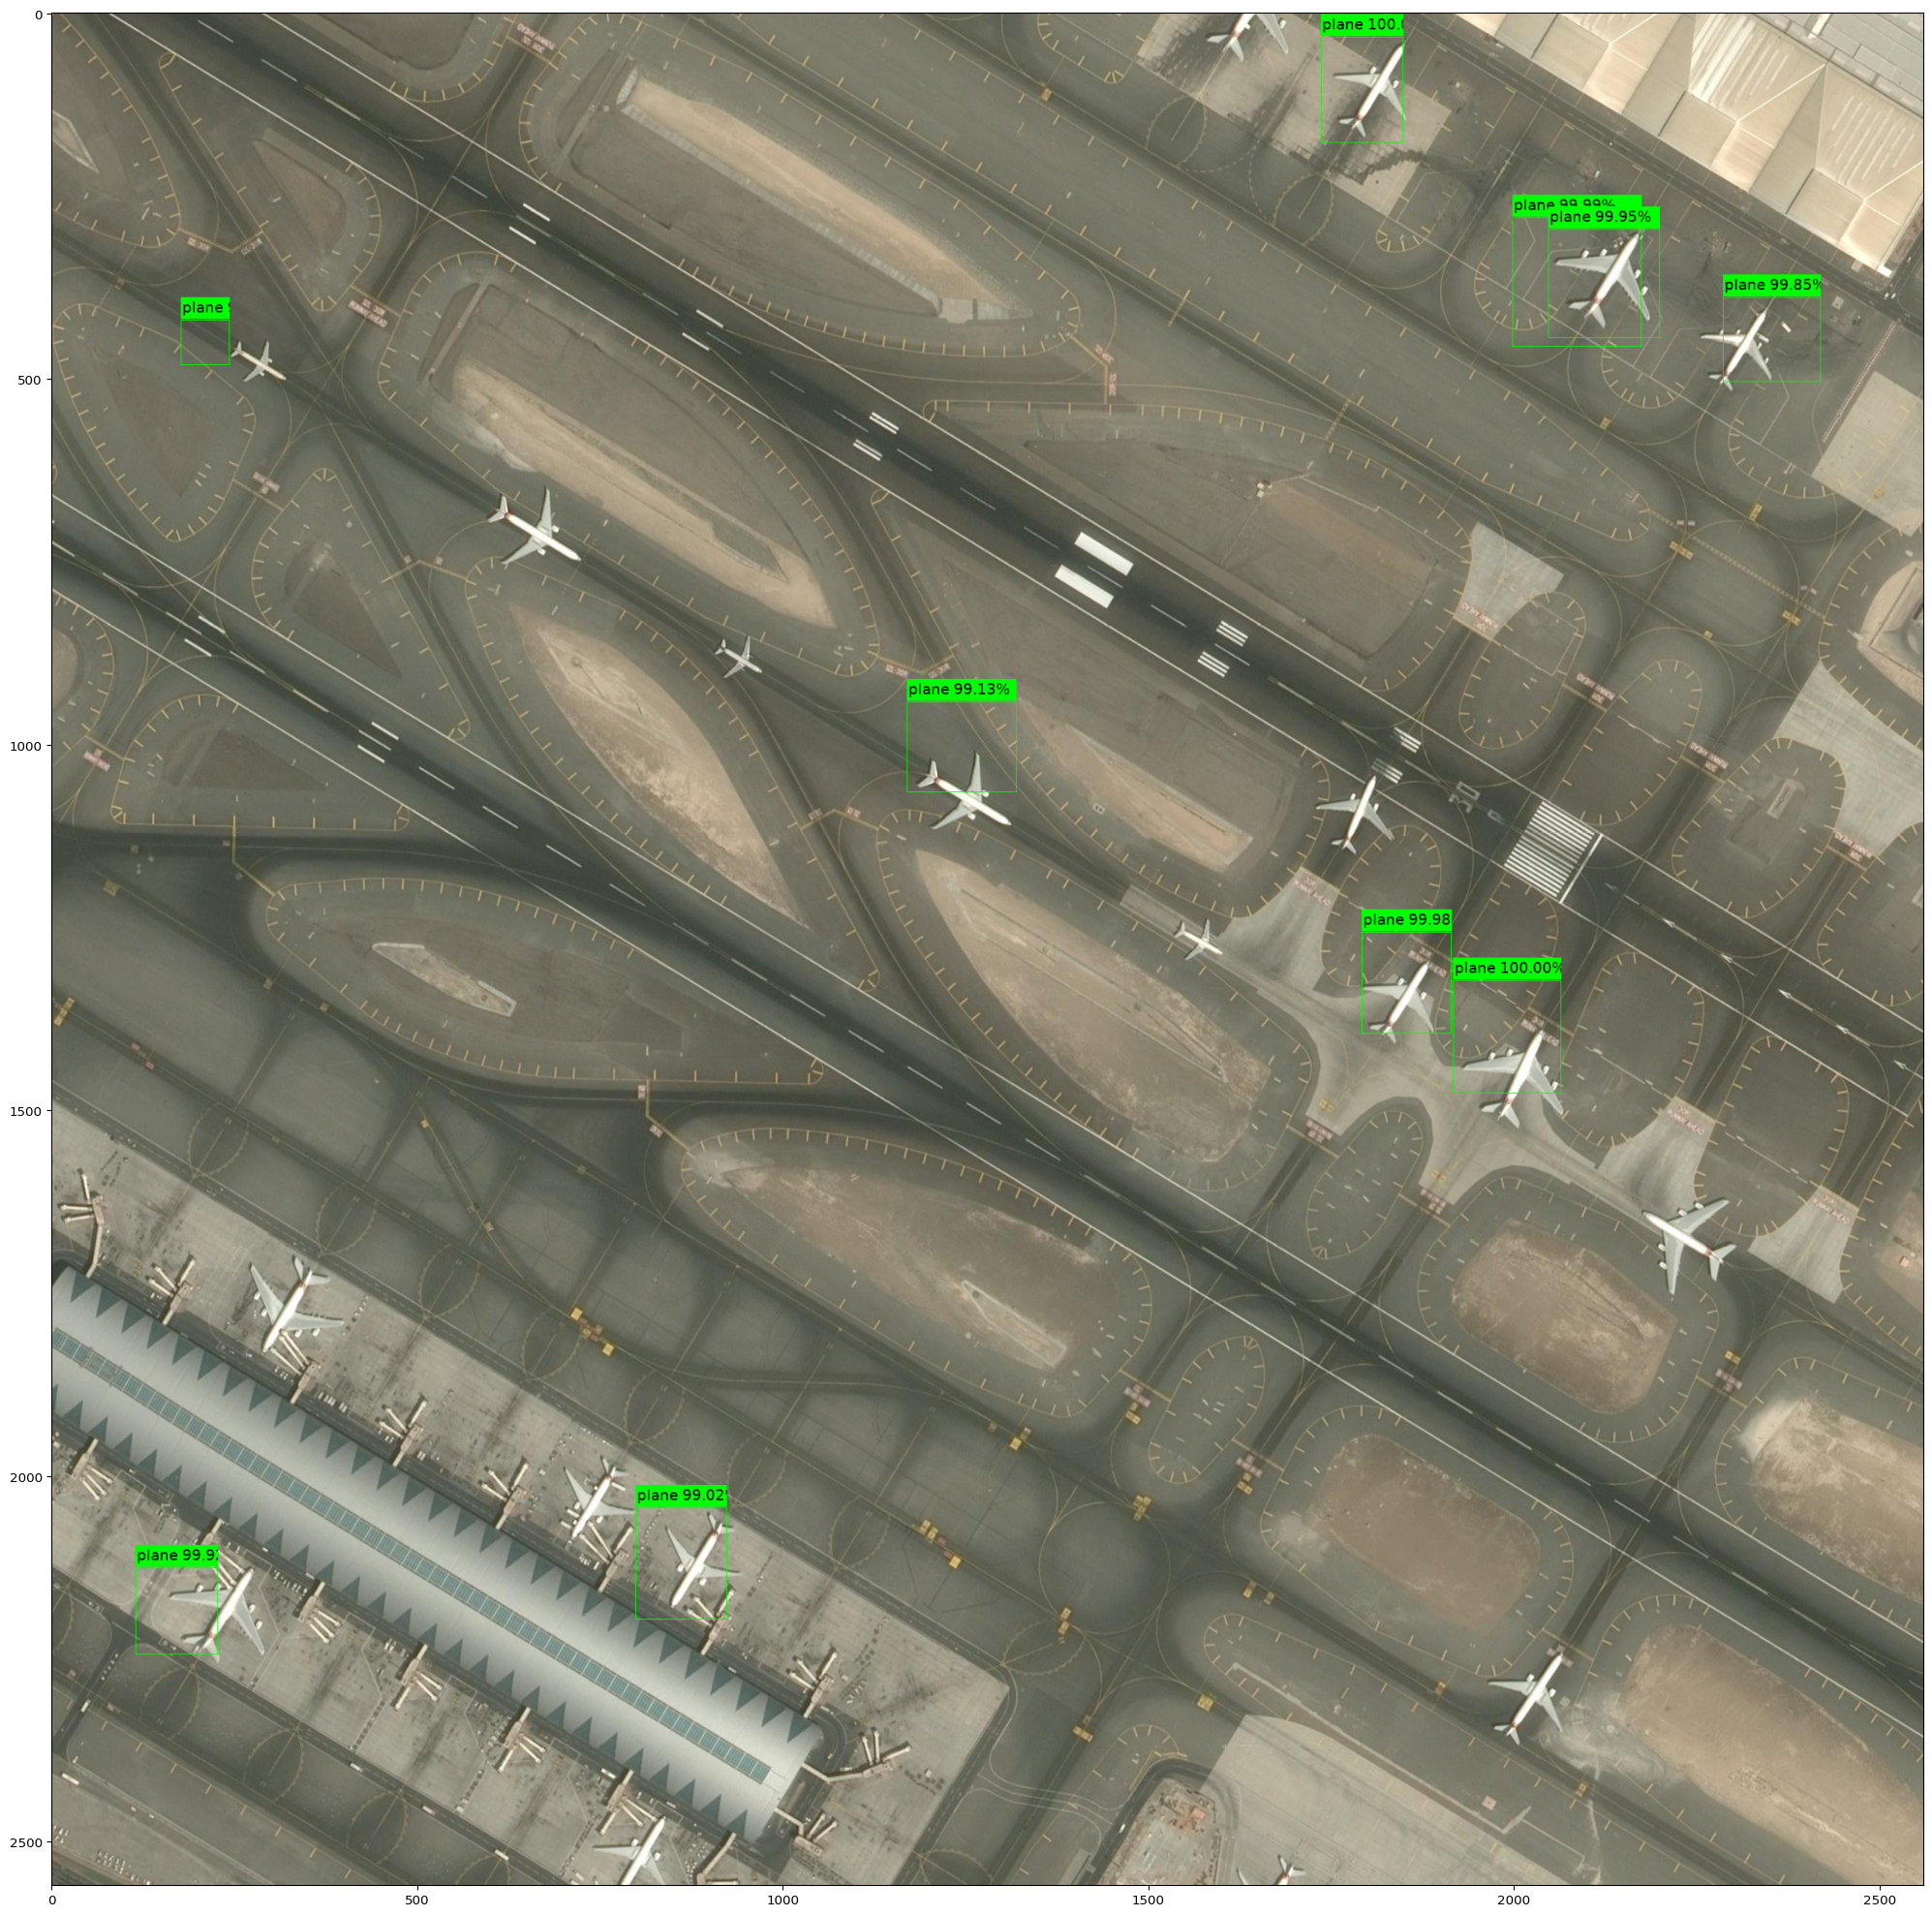

In [ ]:
def make_predictions_show(image_path, model):
    assert os.path.isfile(image_path), "img file " + str(image_path) + " does not exists."
    im = imageio.imread(image_path)
    image = cv2.imread(image_path)
    image = np.array(image, dtype=np.float)
    image = np.uint8(image)

    input_size = config["model"]["input_size"]

    display_image = image.copy()
    image_height, image_width, _ = image.shape
    height_scale, width_scale = input_size/image_height, input_size/image_width

    image = cv2.resize(image, (input_size, input_size))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = preprocess_input(image)

    image = np.expand_dims(image, axis=0)
    y_pred = model.predict(image)
    y_pred = decode_predictions(y_pred=y_pred,input_size=300,nms_max_output_size=400,confidence_threshold=0.8,iou_threshold=0.8,num_predictions=10)

    bbxes = []
    label_maps = ["airplane"]
    scores = []

    for i, pred in enumerate(y_pred[0]):
        classname = label_maps[int(pred[0]) - 1].upper()
        confidence_score = pred[1]

        score = f"{'%.2f' % (confidence_score * 100)}%"

        if confidence_score <= 1 and confidence_score > 0.7:
            xmin = max(int(pred[2] / width_scale), 1)
            ymin = max(int(pred[3] / height_scale), 1)
            xmax = min(int(pred[4] / width_scale), image_width-1)
            ymax = min(int(pred[5] / height_scale), image_height-1)

            bbxes.append({"class": "airplane" , "confidence_score": f"{'%.2f' % (confidence_score * 100)}%", "bbox" : [float(xmin),  float(ymin),  float(xmax), float(ymax)]})

    bbs = BoundingBoxesOnImage([BoundingBox(val["bbox"][0], val["bbox"][1],val["bbox"][2],val["bbox"][3], label="plane" + " " + str(val["confidence_score"])) for val in bbxes], shape=im.shape)
    ia.imshow(bbs.draw_on_image(im))

make_predictions_show("/content/airbus_dataset/images/2314c1b5-ec8f-4212-b42f-43365a13fd20.jpg", model)

In [ ]:
# decoding predictions

def make_predictions(image_path, model):
    assert os.path.isfile(image_path), "img file " + str(image_path) + " does not exists."
    im = imageio.imread(image_path)
    image = cv2.imread(image_path)
    image = np.array(image, dtype=np.float)
    image = np.uint8(image)

    input_size = config["model"]["input_size"]

    display_image = image.copy()
    image_height, image_width, _ = image.shape
    height_scale, width_scale = input_size/image_height, input_size/image_width

    image = cv2.resize(image, (input_size, input_size))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = preprocess_input(image)

    image = np.expand_dims(image, axis=0)
    y_pred = model.predict(image)
    y_pred = decode_predictions(y_pred=y_pred,input_size=300,nms_max_output_size=400,confidence_threshold=0.01,iou_threshold=0.01,num_predictions=100)

    bbxes = []
    label_maps = ["airplane"]
    scores = []

    for i, pred in enumerate(y_pred[0]):
        classname = label_maps[int(pred[0]) - 1].upper()
        confidence_score = pred[1]

        score = f"{'%.2f' % (confidence_score * 100)}%"
        scores.append(score)

        if confidence_score <= 1 and confidence_score > 0.49:
            xmin = max(int(pred[2] / width_scale), 1)
            ymin = max(int(pred[3] / height_scale), 1)
            xmax = min(int(pred[4] / width_scale), image_width-1)
            ymax = min(int(pred[5] / height_scale), image_height-1)

            bbxes.append({"class": "airplane" , "confidence_score": confidence_score, "bbox" : [float(xmin),  float(ymin),  float(xmax), float(ymax)]})

    return bbxes

predictions_dict = {}

with open("/content/test/test.json", "r") as test_file:
  test_json = json.load(test_file)

  for element in test_json.keys():

    if(element.split("|")[0] == "a"):
      predictions_dict[element] = make_predictions("/content/airbus_dataset/images/" + element.split("|")[1], model)
    elif(element.split("|")[0] == "cgi"):
      predictions_dict[element] = make_predictions("/content/cgi_planes_dataset/test/" + element.split("|")[1], model)
    if(element.split("|")[0] == "a"):
      predictions_dict[element] = make_predictions("/content/airbus_dataset/images/" + element.split("|")[1], model)
    elif(element.split("|")[0] == "c"):
      predictions_dict[element] = make_predictions("/content/test/" + element.split("|")[1], model)



In [ ]:
from google.colab import files
files.download("/content/ad_ssd_model_130.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

-- airplane: 16.40%


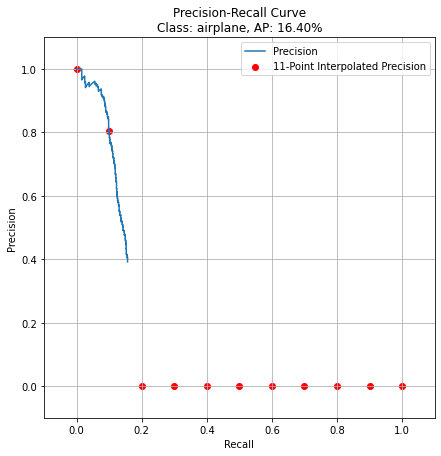

mAP: 16.40%


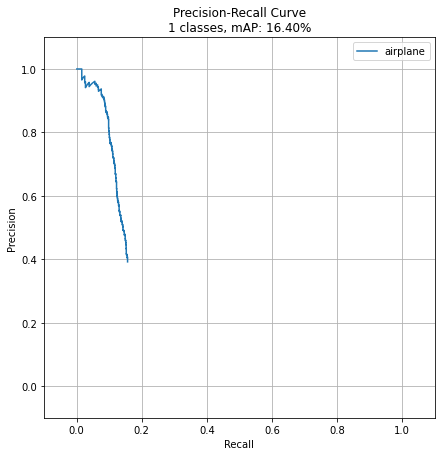

In [ ]:
#evaluation

import enum
import matplotlib.pyplot as plt

iou_threshold = 0.5

ground_truths_dict = json.load(open("/content/test/test.json", "r"))

assert len(list(ground_truths_dict.keys())) == len(list(predictions_dict.keys())), "prediction files does not equal to ground truth files"


aps = []
metrics = {}
label_maps = ["airplane"]

for classname in label_maps:
    detections = []
    all_ground_truths = 0
    for filename in list(predictions_dict.keys()):
        predictions_in_file = [p for p in predictions_dict[filename] if p["class"] == classname]
        ground_truth_in_file = [g for g in ground_truths_dict[filename] if g["class"] == classname]

        all_ground_truths += len(ground_truth_in_file)

        gt_pred_matrix = np.zeros((len(ground_truth_in_file), len(predictions_in_file)))

        for pred_i, pred in enumerate(predictions_in_file):
            for gt_i, gt in enumerate(ground_truth_in_file):
                gt_pred_matrix[gt_i][pred_i] = iou(
                    np.expand_dims(pred["bbox"], axis=0),
                    np.expand_dims(gt["bbox"], axis=0),
                )[0]

        t = np.where(gt_pred_matrix > iou_threshold, 1, 0)
        for gt_i in range(t.shape[0]):
            row = t[gt_i]
            true_positives_per_gt = np.argwhere(row == 1)
            if len(true_positives_per_gt) > 1:
                t[gt_i] = np.zeros_like(row)
                largest_overlap_idx = np.argmax(row)
                t[gt_i][largest_overlap_idx] = 1

        for pred_idx in range(t.shape[1]):
            cols = t[:, pred_idx]
            if (len(np.argwhere(cols == 1)) > 0):
                detections.append([predictions_in_file[pred_idx]["confidence_score"], 1])  # 1 for tp
            else:
                detections.append([predictions_in_file[pred_idx]["confidence_score"], 0])  # 1 for tp

    detections.sort(key=lambda x: x[0], reverse=True)  # highest confidence score first
    detections = np.array(detections)

    precisions, recalls = [], []
    intp_precisions, intp_recalls = [], []

    for i in range(detections.shape[0]):
        detections_for_threshold = detections[:i+1]
        if (detections_for_threshold.shape[0] > 0):
            tp = sum(detections_for_threshold[:, 1])
            precision = tp / len(detections_for_threshold)
            recall = tp / all_ground_truths
            precisions.append(precision)
            recalls.append(recall)

    precisions = np.array(precisions)
    recalls = np.array(recalls)

    for recall in np.arange(0, 1.1, 0.1):
        intp_recalls.append(recall)
        temp = precisions[np.where(recalls >= recall)]
        if len(temp) == 0:
            intp_precisions.append(0)
        else:
            intp_precisions.append(max(temp))

    intp_precisions = np.array(intp_precisions)
    intp_recalls = np.array(intp_recalls)

    ap = intp_precisions.mean()
    aps.append(ap)

    metrics[classname] = {
        "precisions": precisions,
        "recalls": recalls,
    }

    print(f"-- {classname}: {'%.2f' % (ap * 100)}%")

    plt.figure(figsize=(7, 7))
    plt.xlim(-0.1, 1.1)
    plt.ylim(-0.1, 1.1)
    plt.plot(recalls, precisions, label="Precision")
    plt.scatter(intp_recalls, intp_precisions, label="11-Point Interpolated Precision", color="red")
    plt.title(f"Precision-Recall Curve\nClass: {classname.lower()}, AP: {'%.2f' % (ap * 100)}%")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.grid()
    plt.show()
    #plt.savefig(os.path.join(args.output_dir, f"{classname.lower()}_ap-{'%.2f' % ap}.png"))


aps = np.array(aps)
mAP = aps.mean()
print(f"mAP: {'%.2f' % (mAP * 100)}%")

plt.figure(figsize=(7, 7))
for classname in metrics.keys():
    plt.plot(metrics[classname]["recalls"], metrics[classname]["precisions"], label=classname)
plt.title(f"Precision-Recall Curve\n{len(label_maps)} classes, mAP: {'%.2f' % (mAP * 100)}%")
plt.legend()
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)
plt.grid()
#plt.savefig(os.path.join(args.output_dir, f"_all_map-{'%.2f' % mAP}.png"))
